- [빅쿼리 공식문서: Python 라이브러리](https://cloud.google.com/bigquery/docs/python-libraries?hl=ko#features_not_supported_by_pandas-gbq)

In [223]:
# %pip install google-cloud-bigquery

### 라이브러리 import

In [1]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./config/*.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials=credentials, project=credentials.project_id)


import warnings

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

### 사용주기
#### stickiness: DAU/MAU
일간 방문자 대비 한 달 안에 재방문하는 비율이 얼마나 될까?

In [225]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, mau_list AS (
  -- 단순 MAU: 월별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    DATE_TRUNC(event_date, MONTH) AS event_month,
    COUNT(DISTINCT user_pseudo_id) AS mau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY DATE_TRUNC(event_date, MONTH)
  -- ORDER BY event_month
)

-- stickiness 계산: dau/mau
SELECT
  d.event_date,
  -- m.event_month,
  d.dau,
  m.mau,
  ROUND(SAFE_DIVIDE(d.dau, m.mau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY m.event_month) AS sum_of_dau,
FROM mau_list m
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, MONTH) = m.event_month
ORDER BY m.event_month, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_daumau = query_job.to_dataframe()
df_stickiness_daumau.head()

,event_date,dau,mau,stickiness,sum_of_dau
0,2022-08-01,154,7351,2.0950,7864
1,2022-08-02,157,7351,2.1358,7864
2,2022-08-03,174,7351,2.3670,7864
3,2022-08-04,162,7351,2.2038,7864
4,2022-08-05,170,7351,2.3126,7864


In [226]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['mau'],
                         name='mau'
))

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(title_text="MAU vs.DAU 월간 합계 비교 추이")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [227]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_daumau['event_date'],
                         y=df_stickiness_daumau['stickiness'],
))

fig.update_layout(title_text="stickiness: DAU/MAU")
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### stickiness: DAU/WAU
일간 방문자 대비 일주일 안에 재방문하는 비율이 얼마나 될까?

In [228]:
sql = f"""
WITH dau_list AS (
  -- 단순 DAU: 날짜별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, wau_list AS (
  -- 단순 WAU: 주차별 사용자수 (전제조건: 사용자수 = 활성 사용자수)
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
  -- ORDER BY event_week
)

-- stickiness 계산: dau/wau
SELECT
  d.event_date,
  -- w.event_week,
  w.wau,
  d.dau,
  ROUND(SAFE_DIVIDE(d.dau, w.wau)*100,4) AS stickiness,
  SUM(d.dau) OVER (PARTITION BY w.event_week) AS sum_of_dau,
FROM wau_list w
CROSS JOIN dau_list d
WHERE DATE_TRUNC(d.event_date, WEEK(MONDAY)) = w.event_week
ORDER BY w.event_week, d.event_date;
"""

query_job = client.query(sql)
df_stickiness_dauwau = query_job.to_dataframe()
df_stickiness_dauwau.head()

,event_date,wau,dau,stickiness,sum_of_dau
0,2022-08-01,1181,154,13.0398,1190
1,2022-08-02,1181,157,13.2938,1190
2,2022-08-03,1181,174,14.7333,1190
3,2022-08-04,1181,162,13.7172,1190
4,2022-08-05,1181,170,14.3946,1190


In [229]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['wau'],
                         name='wau'
))

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['sum_of_dau'],
                         name='sum of dau'
))

fig.update_layout(
    title_text="WAU vs.DAU 주간 합계 비교 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='사용자 수')

fig.show()

In [230]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_stickiness_dauwau['event_date'],
                         y=df_stickiness_dauwau['stickiness'],
))

fig.update_layout(
    title_text="stickiness: DAU/WAU",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='stickiness (%)')

fig.show()

#### 유입일 이후 방문 간격 분포
사용자는 몇 일에 한 번 방문할까?

In [231]:
sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 유입 일자, 활동 일자, 직전 활동 일자
  SELECT DISTINCT
    user_pseudo_id,
    FIRST_VALUE(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS first_event_date,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)

, user_active_interval AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    IFNULL(DATE_DIFF(event_date, prev_event_date, DAY),0) AS day_diff
  FROM user_active_sequence
  ORDER BY user_pseudo_id, event_date
)

SELECT
  *
FROM user_active_interval
WHERE day_diff != 0
"""

query_job = client.query(sql)
df_visit_interval = query_job.to_dataframe()
df_visit_interval.head()

,user_pseudo_id,event_date,prev_event_date,day_diff
0,1001016485.1302650668,2022-09-26,2022-08-27,30
1,1001016485.1302650668,2022-11-02,2022-09-26,37
2,1001081079.2295351100,2022-10-06,2022-10-01,5
3,1001081079.2295351100,2022-12-16,2022-10-06,71
4,1001261584.8948661538,2023-01-09,2022-11-04,66


In [232]:
import numpy as np

# 사분위수 계산 (q1=12일, q2=27일, q3=50일)
q1, q2, q3 = np.percentile(df_visit_interval["day_diff"], [25, 50, 75])
q1, q2,q3 = int(q1), int(q2), int(q3)
print(q1, q2, q3)

12 27 50


In [233]:
# IQR 계산
iqr = q3 - q1

# Lower & Upper Fence 계산
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# 이상치가 아닌 min/max 값 찾기
non_outliers = df_visit_interval[(df_visit_interval["day_diff"] >= lower_fence) & (df_visit_interval["day_diff"] <= upper_fence)]
min_value = non_outliers["day_diff"].min()

if lower_fence < 0:
    lower_fence = min_value    

lower_fence, upper_fence = int(lower_fence), int(upper_fence)

print(lower_fence, upper_fence)

1 107


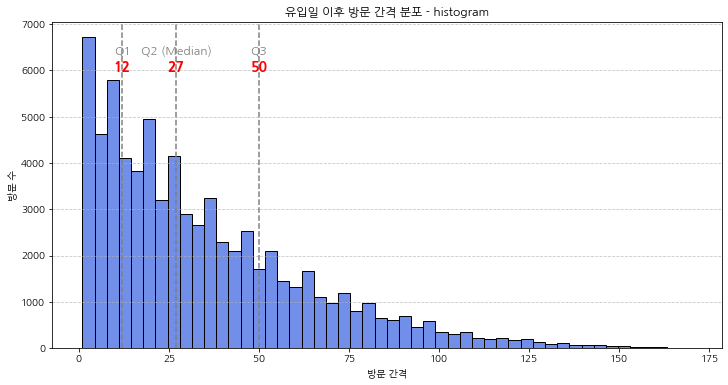

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumGothic')
%matplotlib inline

plt.figure(figsize=(12,6), facecolor='white')
sns.histplot(df_visit_interval['day_diff'], bins=50, color='royalblue')

# 사분위수
for q, label in zip([q1, q2, q3], ["Q1", "Q2 (Median)", "Q3"]):
    plt.axvline(q, color="gray", linestyle="dashed", linewidth=1.5)
    plt.text(q, plt.ylim()[1] * 0.9, label, color="gray", ha="center", fontsize=12)
    plt.text(q, plt.ylim()[1] * 0.85, q, color="red", ha="center", fontsize=14, fontweight="bold")


plt.xlabel("방문 간격")
plt.ylabel("방문 수")
plt.title("유입일 이후 방문 간격 분포 - histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 차트 출력
plt.show()

#### 주차별 리텐션
유입일 이후 주 단위로 봤을 때 얼마나 꾸준히 방문하는가?

In [235]:
sql = f"""
/* weekly range retention */

-- 2) 사용자별 첫방문일 기준 주 차이 계산
WITH week_diff_per_user AS (
  SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff
  FROM (
    -- 1) 사용자별 첫방문일, 방문일 리스트 추출
    SELECT DISTINCT
      user_pseudo_id,
      MIN(event_week) OVER(PARTITION BY user_pseudo_id) AS first_week,
      event_week
    FROM advanced.app_logs_cleaned_target
  )
)
, week_retain AS (
  -- 3) 주 차이별 이용자수 계산
  SELECT
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_user
  FROM week_diff_per_user
  GROUP BY week_diff
)

-- 5) 주 차이별 리텐션 비율 계산
, first_week_retain AS (
  SELECT
    COUNT(DISTINCT user_pseudo_id) AS first_week_retain_user
  FROM week_diff_per_user
  WHERE 1=1
  AND week_diff=0
)

SELECT
  week_.week_diff,
  week_.retain_user,
  first_week_.first_week_retain_user,
  ROUND(SAFE_DIVIDE(week_.retain_user, first_week_.first_week_retain_user)*100, 3) AS retention_ratio
FROM week_retain AS week_
CROSS JOIN first_week_retain AS first_week_
ORDER BY week_.week_diff ASC
"""

query_job = client.query(sql)
df_weekly_retention = query_job.to_dataframe()
df_weekly_retention.head()

,week_diff,retain_user,first_week_retain_user,retention_ratio
0,0,49678,49678,100.000
1,1,4375,49678,8.807
2,2,4599,49678,9.258
3,3,4673,49678,9.407
4,4,4545,49678,9.149


In [236]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_weekly_retention['week_diff'],
                         y=df_weekly_retention['retention_ratio'],
))

fig.update_layout(title_text="주차별 리텐션")
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

### 사용 시간, 요일
#### 사용 시간대 분포

In [237]:
sql = f"""
-- 전체 유저 기준 주로 어느 시간대에 접속했는가?
SELECT
  EXTRACT(HOUR FROM event_time) AS event_hour,
  COUNT(DISTINCT user_pseudo_id) AS user_cnt
FROM advanced.app_logs_cleaned_target
GROUP BY event_hour
ORDER BY event_hour;
"""

query_job = client.query(sql)
df_visithour = query_job.to_dataframe()
df_visithour.head()

,event_hour,user_cnt
0,0,1069
1,1,1065
2,2,1066
3,3,1074
4,4,1058


In [238]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visithour['event_hour'],
                         y=df_visithour['user_cnt'],
))

fig.update_layout(title_text="시간대별 사용자 수 분포")
fig.update_xaxes(title_text='시간 (hour)')
fig.update_yaxes(title_text='사용자 수')

fig.show()

#### 사용 요일 + 시간대 분포

In [239]:
sql = f"""
-- 전체 유저 기준 주로 어느 요일+시간에 접속했는가?
SELECT DISTINCT
  FORMAT_DATETIME("%a %Hh", event_datetime) AS event_dow_hour,  -- 요일 + 시간 출력
  RANK() OVER (ORDER BY event_dow, event_hour) AS order_num,
  COUNT(DISTINCT user_pseudo_id) OVER (PARTITION BY event_dow, event_hour) AS user_cnt
FROM (
  SELECT
    event_datetime,
    event_dow,
    EXTRACT(HOUR FROM event_datetime) AS event_hour,
    user_pseudo_id
  FROM advanced.app_logs_cleaned_target
)
ORDER BY order_num
"""

query_job = client.query(sql)
df_visitdowhour = query_job.to_dataframe()
df_visitdowhour.head()

,event_dow_hour,order_num,user_cnt
0,Mon 00h,1,108
1,Mon 01h,749,110
2,Mon 02h,1409,109
3,Mon 03h,2118,106
4,Mon 04h,2786,108


In [240]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_visitdowhour['event_dow_hour'],
                         y=df_visitdowhour['user_cnt'],
))

fig.update_layout(title_text="요일+시간대별 사용자 수 분포")
fig.update_xaxes(title_text="요일 + 시간")
fig.update_yaxes(title_text='사용자 수')

fig.show()

### 세션, 스크린뷰, 체류시간
#### 일별 유저당 평균 세션 수

In [241]:
sql = f"""
  -- 하루에 사용자들이 평균적으로 몇 번 방문하는가?
  -- 일별 유저당 평균 세션 수
  SELECT
    event_date,
    ROUND(AVG(session_cnt), 2) AS avg_sessions_per_user
  FROM (
    -- 일별 유저별 세션 수
    SELECT
      event_date,
      user_pseudo_id,
      COUNT(DISTINCT session_id) AS session_cnt,
    FROM `advanced.app_logs_cleaned_target`
    GROUP BY event_date, user_pseudo_id
  )
  GROUP BY event_date
  ORDER BY event_date
"""

query_job = client.query(sql)
df_sess_per_day_user = query_job.to_dataframe()
df_sess_per_day_user.head()

,event_date,avg_sessions_per_user
0,2022-08-01,1.0
1,2022-08-02,1.0
2,2022-08-03,1.0
3,2022-08-04,1.0
4,2022-08-05,1.0


In [242]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_sess_per_day_user['event_date'],
                         y=df_sess_per_day_user['avg_sessions_per_user'],
))

fig.update_layout(
    title_text="일별 유저당 평균 세션 수 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='세션 수')

fig.show()

#### 일별 세션당 평균 스크린뷰

In [243]:
sql = f"""
-- 하루에 한 번 방문할 때 몇 개의 화면을 보는가?
-- 일별 세션당 평균 스크린뷰, 유니크뷰
SELECT
  event_date,
  ROUND(AVG(screen_view_cnt), 2) AS avg_screen_view_per_sess,
  ROUND(AVG(unique_view_cnt), 2) AS avg_unique_view_per_sess,
FROM (
  -- 일별 세션별 스크린뷰, 유니크뷰
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    COUNT(*) AS screen_view_cnt,
    COUNT(DISTINCT firebase_screen) AS unique_view_cnt,
  FROM `advanced.app_logs_cleaned_target`
  WHERE event_name='screen_view'
  GROUP BY event_date, user_pseudo_id, session_id
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_screenview_per_sess = query_job.to_dataframe()
df_screenview_per_sess.head()

,event_date,avg_screen_view_per_sess,avg_unique_view_per_sess
0,2022-08-01,3.06,3.05
1,2022-08-02,3.46,3.43
2,2022-08-03,3.27,3.25
3,2022-08-04,3.30,3.30
4,2022-08-05,3.18,3.16


In [244]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_screen_view_per_sess'],
                         name="screen view"
))

fig.add_trace(go.Scatter(x=df_screenview_per_sess['event_date'],
                         y=df_screenview_per_sess['avg_unique_view_per_sess'],
                         name="unique view"
))

fig.update_layout(
    title_text="일별 세션당 평균 스크린뷰 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='스크린뷰')

fig.show()

#### 일별 세션당 화면당 평균 체류시간

In [245]:
sql = f"""
-- 하루에 한 번 방문할 때 화면당 얼마나 머무르는가?
-- 일별 세션당 화면당 평균 체류시간 (firebase_screen별 체류시간)
SELECT
  event_date,
  ROUND(AVG(duration_time),2) AS avg_duration_time_per_screen,
FROM (
  -- 일별 세션당 화면당 체류시간
  SELECT
    event_date,
    user_pseudo_id,
    session_id,
    firebase_screen,
    DATETIME_DIFF(MAX(event_datetime), MIN(event_datetime), SECOND) AS duration_time,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date, user_pseudo_id, session_id, firebase_screen
)
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_duration_per_screen = query_job.to_dataframe()
df_duration_per_screen.head()

,event_date,avg_duration_time_per_screen
0,2022-08-01,10.99
1,2022-08-02,12.11
2,2022-08-03,11.63
3,2022-08-04,11.10
4,2022-08-05,10.80


In [246]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_duration_per_screen['event_date'],
                         y=df_duration_per_screen['avg_duration_time_per_screen'],
))

fig.update_layout(
    title_text="일별 세션당 화면당 평균 체류시간",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98    
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='체류시간 (초)')

fig.show()

### 주문
#### 일별 주문수 추이

In [247]:
sql = f"""
-- 일일 주문한 유저 수
SELECT
  event_date,
  COUNT(DISTINCT user_id) AS order_users_cnt
FROM advanced.app_logs_cleaned_target
WHERE event_name = 'click_payment'
GROUP BY event_date
ORDER BY event_date
"""

query_job = client.query(sql)
df_order_user = query_job.to_dataframe()
df_order_user.head()

,event_date,order_users_cnt
0,2022-08-01,12
1,2022-08-02,21
2,2022-08-03,24
3,2022-08-04,12
4,2022-08-05,10


In [248]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_order_user['event_date'],
                         y=df_order_user['order_users_cnt'],
))

fig.update_layout(
    title_text="일별 주문 유저 수 추이",
    margin_l=60,
    margin_r=20,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98 
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문한 사람 수')

fig.show()

#### DAU 대비 주문 유저 수 추이

In [249]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
  ORDER BY event_date
)

-- DAU와 일별 주문 유저 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM dau_list d
INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
ORDER BY d.event_date ASC;
"""

query_job = client.query(sql)
df_order_ratio = query_job.to_dataframe()
df_order_ratio.head()

,event_date,dau,order_users_cnt,order_ratio
0,2022-08-01,154,12,7.792
1,2022-08-02,157,21,13.376
2,2022-08-03,174,24,13.793
3,2022-08-04,162,12,7.407
4,2022-08-05,170,10,5.882


In [250]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['order_ratio'],
                         name="order ratio",
                         line={'color':'orange'}),
              secondary_y = False
)

fig.add_trace(go.Scatter(x=df_order_ratio['event_date'],
                         y=df_order_ratio['dau'],
                         name="DAU",
                         line={'color':'darkgray'}),
              secondary_y = True
)

fig.update_layout(
    title_text="DAU 대비 주문 유저 수 추이",
    margin_l=70,
    margin_r=20,
    margin_b=50,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.01,
    legend_x=0.93 
)
fig.update_xaxes(title_text="날짜")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()

#### WAU 대비 주문 유저 수 추이

In [251]:
sql = f"""
WITH wau_list AS (
  SELECT
    event_week,
    COUNT(DISTINCT user_pseudo_id) AS wau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_week
)
, order_cnt_list_w AS (
  -- 주차별 주문 유저 수
  SELECT
    event_week,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_week
)

-- WAU와 주간 주문 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  w.event_week,
  w.wau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, w.wau) * 100, 3) AS order_ratio  -- 주문율
FROM wau_list w
INNER JOIN order_cnt_list_w o ON w.event_week = o.event_week
ORDER BY w.event_week ASC

"""

query_job = client.query(sql)
df_order_ratio_w = query_job.to_dataframe()
df_order_ratio_w.head()

,event_week,wau,order_users_cnt,order_ratio
0,2022-08-01,1181,120,10.161
1,2022-08-08,1367,105,7.681
2,2022-08-15,1985,255,12.846
3,2022-08-22,2191,225,10.269
4,2022-08-29,2612,267,10.222


In [252]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_order_ratio_w['event_week'],
                         y=df_order_ratio_w['order_ratio'],
                         name="order ratio",
                         line={'color':'orange'}),
              secondary_y = False
)

fig.add_trace(go.Scatter(x=df_order_ratio_w['event_week'],
                         y=df_order_ratio_w['wau'],
                         name="WAU",
                         line={'color':'darkgray'}),
              secondary_y = True
)

fig.update_layout(
    title_text="WAU 대비 주문 유저 수 추이",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98  
)
fig.update_xaxes(title_text="주차")
fig.update_yaxes(title_text='주문율 (%)', secondary_y=False)
fig.update_yaxes(title_text='사용자 수', secondary_y=True)

fig.show()

### 유저 세분화

#### 일회성 vs. 재방문

In [ ]:
# 일회성 vs. 재방문

sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 활동 일자, 직전 활동 일자
  -- 회원 49678명
  SELECT DISTINCT
    user_pseudo_id,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)
, user_only_1day AS (
  -- 2. 일회성 유저 13151명
  SELECT DISTINCT
    user_pseudo_id,
    'one_day' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) = 1
  )
)
, user_revisit AS (
  -- 3. 재방문 유저 36527명
  SELECT DISTINCT
    user_pseudo_id,
    'revisit' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) > 1
  )
)

SELECT
  COUNT(DISTINCT IF(visit_interval_cat='one_day',user_pseudo_id,NULL)) AS one_day_users,
  COUNT(DISTINCT IF(visit_interval_cat='revisit',user_pseudo_id,NULL)) AS revisit_users,
FROM (
  SELECT * FROM user_only_1day 
  UNION DISTINCT 
  SELECT * FROM user_revisit
)
"""

query_job = client.query(sql)
df_visit_seg1 = query_job.to_dataframe()
df_visit_seg1.head()

,one_day_users,revisit_users
0,13151,36527


In [4]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Pie(
        # labels=list(df_visit_seg1.columns),
        labels=['일회성 유저','재방문 유저'],
        values=list(df_visit_seg1.values[0]),
        textinfo='value+percent+label'
))

fig.update_layout(
    # title_text="회원 유저의 방문 주기 구분",
    width=550,
    # margin_l=0,
    # margin_r=0,
    margin_b=50,
    margin_t=50,
    showlegend=False,
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)

fig.show()

#### 일회성 vs. 단기 vs. 중기 vs. 장기

재방문 주기 패턴

1. 유저 그룹 정의
- 일회성 유저: 재방문 없음.
- 단기 재방문자: 14일 이내 재방문.
- 중기 재방문자: 15~30일 이내 재방문.
- 장기 재방문자: 30일 초과 재방문.

2. 1에 대한 기준 설정  
- 각 유저별로 방문 간격 유형 카운팅 (단기 2번, 중기 2번, ..)
- 위에 대해 최빈 유형으로 해당 유저의 그룹을 정의함. (단기 2번, 중기 1번, 장기 0번 → 단기 재방문자 그룹)
- 최빈 유형이 다수인 경우, 최신 유형으로 유저의 그룹을 정의함. (단기 2번, 중기 2번, 장기 1번 / 최신 방문 주기가 '중기'에 해당함. → 중기 재방문자 그룹)

In [5]:
# 일회성 vs. 단기 vs. 중기 vs. 장기

sql = f"""
WITH user_active_sequence AS (
  -- 1. 유저별 활동 일자 시퀀스: 유입 일자, 활동 일자, 직전 활동 일자
  -- 회원 49678명
  SELECT DISTINCT
    user_pseudo_id,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)
, user_only_1day AS (
  -- 2-1. 정합성 검증: 하루만 사용하고 이탈한 사람 13151명
  SELECT DISTINCT
    user_pseudo_id,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) = 1
  )
)
, user_visit_interval_calc AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산 (36527명; 49678-13151)
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    DATE_DIFF(event_date, prev_event_date, DAY) AS day_diff,
    ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date DESC) AS visit_interval_order,  -- 방문 간격 순서 (맨 마지막을 1로 둠.)
    CASE
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) <= 14 THEN 'short'
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) BETWEEN 15 AND 30 THEN 'mid'
      ELSE 'long'
    END AS visit_interval_cat,
  FROM user_active_sequence
  WHERE 1=1
  AND user_pseudo_id NOT IN (SELECT * FROM user_only_1day)  -- 재방문한 유저만 남김
  AND prev_event_date IS NOT NULL  -- 유입일 이전 제외
  AND DATE_DIFF(event_date, prev_event_date, DAY) != 0
)
, visit_interval_count_per_user AS (
  -- 3. 유저별 방문 간격 유형별 카운팅
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    COUNT(*) AS cnt,
  FROM user_visit_interval_calc
  GROUP BY user_pseudo_id, visit_interval_cat
)
, mode_visit_interval_cat_per_user AS (
  -- 4. 유저별 최빈 방문 간격 유형 추출 (공동 1위 존재함.)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    cnt,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY cnt DESC) AS cat_cnt_order
  FROM visit_interval_count_per_user
  QUALIFY cat_cnt_order = 1
)

, result AS (
  -- 한번만 방문한 유저 (13151명)
  SELECT
    user_pseudo_id,
    'one_day' AS visit_interval_cat,
  FROM user_only_1day

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 하나인 경우: 바로 분류 (26370명)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM mode_visit_interval_cat_per_user
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 여러 개인 경우: 최신 방문 간격 유형으로 분류 (10157명)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_visit_interval_calc
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )
  AND visit_interval_order = 1
)


SELECT
  COUNT(DISTINCT IF(visit_interval_cat='one_day',user_pseudo_id,NULL)) AS one_day_users,
  COUNT(DISTINCT IF(visit_interval_cat='short',user_pseudo_id,NULL)) AS short_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='mid',user_pseudo_id,NULL)) AS mid_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='long',user_pseudo_id,NULL)) AS long_term_users,
--  COUNT(DISTINCT user_pseudo_id) AS tot_member_users,
FROM result
"""

query_job = client.query(sql)
df_visit_seg2 = query_job.to_dataframe()
df_visit_seg2.head()

,one_day_users,short_term_users,mid_term_users,long_term_users
0,13151,9661,8517,18349


In [6]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Pie(
        # labels=list(df_visit_seg2.columns),
        labels=['일회성 유저','단기 재방문 유저','중기 재방문 유저','장기 재방문 유저'],
        values=list(df_visit_seg2.values[0]),
        textinfo='value+percent+label'
))

fig.update_layout(
    # title_text="회원 유저의 방문 주기 구분",
    width=550,
    # margin_l=0,
    # margin_r=0,
    margin_b=50,
    margin_t=50,
    showlegend=False,
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)

fig.show()

#### 일회성 vs. 재방문 (단기, 중기, 장기)

In [11]:
sql = f"""
WITH user_active_sequence AS (
  -- 1. (49678명) 회원 유저별 활동 일자 시퀀스: 활동 일자, 직전 활동 일자
  SELECT DISTINCT
    user_pseudo_id,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)
, user_only_1day AS (
  -- 일회성 유저 13151명
  SELECT DISTINCT
    user_pseudo_id,
    'one_day' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) = 1
  )
)
, user_revisit AS (
  -- 재방문 유저 36527명
  SELECT DISTINCT
    user_pseudo_id,
    'revisit' AS visit_interval_cat,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) > 1
  )
)

, user_visit_interval_calc AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산 (36527명; 49678-13151)
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    DATE_DIFF(event_date, prev_event_date, DAY) AS day_diff,
    ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date DESC) AS visit_interval_order,  -- 방문 간격 순서 (맨 마지막을 1로 둠.)
    CASE
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) <= 14 THEN 'short'
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) BETWEEN 15 AND 30 THEN 'mid'
      ELSE 'long'
    END AS visit_interval_cat,
  FROM user_active_sequence
  WHERE 1=1
  AND user_pseudo_id IN (SELECT user_pseudo_id FROM user_revisit)  -- 재방문 유저 대상
  AND prev_event_date IS NOT NULL  -- 유입일 이전 제외
  AND DATE_DIFF(event_date, prev_event_date, DAY) != 0
)
, visit_interval_count_per_user AS (
  -- 3. 유저별 방문 간격 유형별 카운팅
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    COUNT(*) AS cnt,
  FROM user_visit_interval_calc
  GROUP BY user_pseudo_id, visit_interval_cat
)
, mode_visit_interval_cat_per_user AS (
  -- 4. 유저별 최빈 방문 간격 유형 추출 (공동 1위 존재함.)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    cnt,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY cnt DESC) AS cat_cnt_order
  FROM visit_interval_count_per_user
  QUALIFY cat_cnt_order = 1
)

, result AS (

  -- 일회성 유저
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_only_1day

  UNION DISTINCT

  -- 재방문 유저
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_revisit

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 하나인 경우: 바로 분류
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM mode_visit_interval_cat_per_user
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 여러 개인 경우: 최신 방문 간격 유형으로 분류
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_visit_interval_calc
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )
  AND visit_interval_order = 1
)


SELECT
  COUNT(DISTINCT IF(visit_interval_cat='one_day',user_pseudo_id,NULL)) AS oneday_users,
  COUNT(DISTINCT IF(visit_interval_cat='revisit',user_pseudo_id,NULL)) AS revisit_users,
  COUNT(DISTINCT IF(visit_interval_cat='short',user_pseudo_id,NULL)) AS short_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='mid',user_pseudo_id,NULL)) AS mid_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='long',user_pseudo_id,NULL)) AS long_term_users,
FROM result
"""

query_job = client.query(sql)
df_visit_seg_tot = query_job.to_dataframe()
df_visit_seg_tot.head()

,oneday_users,revisit_users,short_term_users,mid_term_users,long_term_users
0,13151,36527,9661,8517,18349


In [46]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Sunburst(
        labels=['일회성 유저','재방문 유저','단기 재방문','중기 재방문','장기 재방문'],
        parents=['','','재방문 유저','재방문 유저','재방문 유저'],
        values=list(df_visit_seg_tot.values[0]),
        textinfo="value+label+percent parent",  # label,text,value,current path,percent root,percent entry,percent parent
        branchvalues="total",
        # insidetextorientation='tangential'
))


fig.update_layout(
    width=550,
    margin_l=10,
    margin_r=10,
    margin_b=10,
    margin_t=10,
    showlegend=False,
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)


fig.show()

#### 단기 vs. 중기 vs. 장기

In [ ]:
# 단기 vs. 중기 vs. 장기

sql = f"""
WITH user_active_sequence AS (
  -- 1. (49678명) 회원 유저별 활동 일자 시퀀스: 활동 일자, 직전 활동 일자
  SELECT DISTINCT
    user_pseudo_id,
    event_date,
    LAG(event_date) OVER (PARTITION BY user_pseudo_id ORDER BY event_date) AS prev_event_date,
  FROM advanced.app_logs_cleaned_target
)
, user_revisit AS (
  -- 2. 재방문 유저 36527명
  SELECT DISTINCT
    user_pseudo_id,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM user_active_sequence
    GROUP BY user_pseudo_id
    HAVING COUNT(DISTINCT event_date) > 1
  )
)

, user_visit_interval_calc AS (
  -- 2. 유저별 유입일 이후 각 방문 간격 계산 (36527명; 49678-13151)
  SELECT
    user_pseudo_id,
    event_date,
    prev_event_date,
    DATE_DIFF(event_date, prev_event_date, DAY) AS day_diff,
    ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date DESC) AS visit_interval_order,  -- 방문 간격 순서 (맨 마지막을 1로 둠.)
    CASE
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) <= 14 THEN 'short'
      WHEN DATE_DIFF(event_date, prev_event_date, DAY) BETWEEN 15 AND 30 THEN 'mid'
      ELSE 'long'
    END AS visit_interval_cat,
  FROM user_active_sequence
  WHERE 1=1
  AND user_pseudo_id IN (SELECT * FROM user_revisit)  -- 재방문 유저 대상
  AND prev_event_date IS NOT NULL  -- 유입일 이전 제외
  AND DATE_DIFF(event_date, prev_event_date, DAY) != 0
)
, visit_interval_count_per_user AS (
  -- 3. 유저별 방문 간격 유형별 카운팅
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    COUNT(*) AS cnt,
  FROM user_visit_interval_calc
  GROUP BY user_pseudo_id, visit_interval_cat
)
, mode_visit_interval_cat_per_user AS (
  -- 4. 유저별 최빈 방문 간격 유형 추출 (공동 1위 존재함.)
  SELECT
    user_pseudo_id,
    visit_interval_cat,
    cnt,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY cnt DESC) AS cat_cnt_order
  FROM visit_interval_count_per_user
  QUALIFY cat_cnt_order = 1
)

, result AS (
  -- 최빈 방문 간격 유형이 하나인 경우: 바로 분류
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM mode_visit_interval_cat_per_user
  WHERE user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )

  UNION DISTINCT

  -- 최빈 방문 간격 유형이 여러 개인 경우: 최신 방문 간격 유형으로 분류
  SELECT
    user_pseudo_id,
    visit_interval_cat,
  FROM user_visit_interval_calc
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM mode_visit_interval_cat_per_user
    GROUP BY user_pseudo_id
    HAVING COUNT(*) = 1
  )
  AND visit_interval_order = 1
)


SELECT
  COUNT(DISTINCT IF(visit_interval_cat='short',user_pseudo_id,NULL)) AS short_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='mid',user_pseudo_id,NULL)) AS mid_term_users,
  COUNT(DISTINCT IF(visit_interval_cat='long',user_pseudo_id,NULL)) AS long_term_users,
FROM result
"""

query_job = client.query(sql)
df_visit_seg3 = query_job.to_dataframe()
df_visit_seg3.head()

,short_term_users,mid_term_users,long_term_users
0,9661,8517,18349


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Pie(
        # labels=list(df_visit_seg3.columns),
        labels=['단기 재방문 유저','중기 재방문 유저','장기 재방문 유저'],
        values=list(df_visit_seg3.values[0]),
        textinfo='value+percent+label'
))

fig.update_layout(
    # title_text="회원 유저의 방문 주기 구분",
    width=550,
    # margin_l=0,
    # margin_r=0,
    margin_b=50,
    margin_t=50,
    showlegend=False,
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)

fig.show()

#### 연휴 유입 vs. 연휴 외 유입

In [9]:
# 연휴 유입 vs. 연휴 외 유입
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)
, revisit_user_logs AS (
  -- 재방문 유저 로그
  SELECT
    *
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'one_day'
  )
)
, result AS (
  -- 연휴 유입 2901명
  SELECT
    'holiday' AS user_segment,
    user_pseudo_id,
  FROM revisit_user_logs
  GROUP BY user_pseudo_id
  HAVING MIN(event_date) IN (SELECT holiday_date FROM holiday)

  UNION DISTINCT

  -- 연휴 외 유입 33626명
  SELECT
    'normalday' AS user_segment,
    user_pseudo_id,
  FROM revisit_user_logs
  GROUP BY user_pseudo_id
  HAVING MIN(event_date) NOT IN (SELECT holiday_date FROM holiday)
)


SELECT
  COUNT(DISTINCT IF(user_segment='holiday',user_pseudo_id,NULL)) AS holiday_inflow,
  COUNT(DISTINCT IF(user_segment='normalday',user_pseudo_id,NULL)) AS normalday_inflow,
FROM result
"""

query_job = client.query(sql)
df_holiday_seg = query_job.to_dataframe()
df_holiday_seg.head()

,holiday_inflow,normalday_inflow
0,2901,33626


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Pie(
        # labels=list(df_visit_seg3.columns),
        labels=['연휴 유입','연휴 외 유입'],
        values=list(df_holiday_seg.values[0]),
        textinfo='value+percent+label'
))

fig.update_layout(
    width=550,
    # margin_l=0,
    # margin_r=0,
    margin_b=50,
    margin_t=50,
    showlegend=False,
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)

fig.show()

#### 일회성 vs. 재방문 (연휴, 연휴 외)

In [47]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)
, revisit_user_logs AS (
  -- 재방문 유저 로그
  SELECT
    *
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'one_day'
  )
)
, result AS (
  -- 일회성 유저 13151명
  SELECT 
    visit_interval_cat AS user_segment,
    user_pseudo_id, 
  FROM advanced.app_logs_target_visit_seg
  WHERE visit_interval_cat = 'one_day'

  UNION DISTINCT

  -- 재방문 유저
  SELECT DISTINCT
    'revisit' AS user_segment,
    user_pseudo_id
  FROM revisit_user_logs

  UNION DISTINCT

  -- 연휴 유입 2901명
  SELECT
    'holiday' AS user_segment,
    user_pseudo_id,
  FROM revisit_user_logs
  GROUP BY user_pseudo_id
  HAVING MIN(event_date) IN (SELECT holiday_date FROM holiday)

  UNION DISTINCT

  -- 연휴 외 유입 33626명
  SELECT
    'normalday' AS user_segment,
    user_pseudo_id,
  FROM revisit_user_logs
  GROUP BY user_pseudo_id
  HAVING MIN(event_date) NOT IN (SELECT holiday_date FROM holiday)
)


SELECT
  COUNT(DISTINCT IF(user_segment='one_day',user_pseudo_id,NULL)) AS oneday_user,
  COUNT(DISTINCT IF(user_segment='revisit',user_pseudo_id,NULL)) AS revisit_user,
  COUNT(DISTINCT IF(user_segment='holiday',user_pseudo_id,NULL)) AS holiday_inflow,
  COUNT(DISTINCT IF(user_segment='normalday',user_pseudo_id,NULL)) AS normalday_inflow,
FROM result
"""

query_job = client.query(sql)
df_holiday_seg_tot = query_job.to_dataframe()
df_holiday_seg_tot.head()

,oneday_user,revisit_user,holiday_inflow,normalday_inflow
0,13151,36527,2901,33626


In [48]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Sunburst(
        labels=['일회성 유저','재방문 유저','연휴 유입','연휴 외 유입'],
        parents=['','','재방문 유저','재방문 유저'],
        values=list(df_holiday_seg_tot.values[0]),
        textinfo="value+label+percent parent",  # label,text,value,current path,percent root,percent entry,percent parent
        branchvalues="total",
        # insidetextorientation='tangential'
))


fig.update_layout(
    width=550,
    margin_l=10,
    margin_r=10,
    margin_b=10,
    margin_t=10,
    showlegend=False,
    # legend_yanchor="top",
    # legend_xanchor="right",
    # legend_y=0.98,
    # legend_x=0.98,
)


fig.show()

### 주문 퍼널

#### 일회성 vs. 재방문: 전체 기간

In [255]:
sql = f"""
/* 주문 퍼널: 일회성 유저 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  -- 일회성 유저 전체 인원인 13151명, 분석 대상 로그 수 39114건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
  
)

, one_day_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 39114건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM one_day_user_logs
)
, one_day_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM one_day_funnel_annot
)
, one_day_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM one_day_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 재방문 유저 */

, revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  -- 재방문 유저 전체 인원인 36527명, 분석 대상 로그 수 273441건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
  
)

, revisit_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 273441건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM revisit_user_logs
)
, revisit_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM revisit_funnel_annot
)
, revisit_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM revisit_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'one_day' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM one_day_funnel_cnt
CROSS JOIN one_day_tot
-- ORDER BY funnel_step ASC

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'revisit' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM revisit_funnel_cnt
CROSS JOIN revisit_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_visit = query_job.to_dataframe()
df_order_funnel_visit.head()

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,one_day,1,13151,13151,1.000
1,one_day,2,9763,13151,0.742
2,one_day,3,2539,13151,0.193
3,one_day,4,1616,13151,0.123
4,revisit,1,36527,36527,1.000


In [256]:
funnel_oneday = df_order_funnel_visit.loc[df_order_funnel_visit['user_segment']=='one_day']
funnel_revisit = df_order_funnel_visit.loc[df_order_funnel_visit['user_segment']=='revisit']


fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_oneday['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'one-day users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_revisit['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'revisit users',
    textinfo = 'value+percent initial'
))

fig.update_layout(
    title_text="주문 퍼널 전환율: 일회성 유저 vs. 재방문 유저",
    margin_l=10,
    margin_r=10,
    margin_b=50,
    margin_t=70,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98 
)


fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정

##### 정규성 검정
- 모수 검정의 가정: 정규성 만족, 등분산성 만족
- 모수 검정 가능 여부를 알아보기 위해 정규성 검증을 진행한다.

In [257]:
sql = f"""
/* 주문 횟수: 일회성 vs. 재방문 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)


SELECT
  'one_day' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM one_day_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'revisit' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM revisit_user_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_order_cnt_visit = query_job.to_dataframe()
df_order_cnt_visit.head()

,user_segment,user_pseudo_id,order_cnt
0,one_day,3796256208.8254777141,0
1,one_day,3691744049.5907601082,0
2,one_day,4985578910.4689216409,0
3,one_day,8334594106.4502045493,0
4,one_day,2630984766.1548148675,0


In [258]:
import scipy.stats as stats

df_oneday_order_cnt = df_order_cnt_visit.loc[df_order_cnt_visit['user_segment']=='one_day', 'order_cnt']
df_revisit_order_cnt = df_order_cnt_visit.loc[df_order_cnt_visit['user_segment']=='revisit', 'order_cnt']

# 일회성 유저에 대한 주문 횟수 리스트 (모든 유저 0회 혹은 1회)
oneday_shapiro = stats.shapiro(df_oneday_order_cnt)

# 재방문 유저에 대한 주문 횟수 리스트
revisit_shapiro = stats.shapiro(df_revisit_order_cnt)

print(oneday_shapiro) 
print(revisit_shapiro)

ShapiroResult(statistic=0.3838534355163574, pvalue=0.0)
ShapiroResult(statistic=0.5888256430625916, pvalue=0.0)


- 검증 결과 p값이 0.05를 넘지 않으므로 정규성을 만족하지 못한다.
- 이에 따라 비모수 검정인 mann-whitney test를 진행해야 한다.

##### Mann-Whitney U test

- 귀무가설: 일회성 유저와 재방문 유저 간의 평균 주문수 차이는 없다.
- 대립가설: 일회성 유저보다 재방문 유저의 평균 주문 수가 더 클 것이다.

In [259]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(df_oneday_order_cnt.astype(float), df_revisit_order_cnt.astype(float))
print(stat, p)

203702582.0 4.732275805405372e-273


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 재방문 유저의 주문 수가 유의미하게 더 크다.

##### 효과 크기 측정: Rank-Biserial Correlation

In [260]:
n1 = len(df_oneday_order_cnt)
n2 = len(df_revisit_order_cnt)
result = (2 * stat) / (n1 * n2) - 1

print(f"Rank-Biserial Correlation: {result:.3f}")

Rank-Biserial Correlation: -0.152


- 측정 결과 -0.152로 재방문 유저가 일회성 유저보다 주문 수가 많지만 그 효과는 작다.

#### 통계적 검정: 그룹간 주문율 차이 검정

##### 2 proportion z-test

- 귀무가설: 일회성 유저와 재방문 유저 간의 주문율 차이는 없다.
- 대립가설: 일회성 유저보다 재방문 유저의 주문율이 더 클 것이다.

In [261]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

count = np.array([
    funnel_oneday.loc[funnel_oneday['funnel_step']==4,'funnel_users'].values[0],
    funnel_revisit.loc[funnel_revisit['funnel_step']==4,'funnel_users'].values[0]
])


nobs = np.array([
    funnel_oneday['tot_users'].values[0],
    funnel_revisit['tot_users'].values[0]
])

proportions_ztest(count=count, nobs=nobs)

(-34.26151194263467, 2.9391033029695184e-257)

- 검증 결과 p값이 0.05보다 작으므로 대립가설을 채택한다.
- 즉, 일회성 유저보다 재방문 유저의 주문율이 유의미하게 더 크다.

##### 효과 크기 측정: Risk Ratio

In [262]:
risk_ratio = funnel_revisit.loc[funnel_revisit['funnel_step']==4,'conversion_rate'].values[0] / funnel_oneday.loc[funnel_oneday['funnel_step']==4,'conversion_rate'].values[0]
print(f"Risk Ratio: {risk_ratio:.3f}")

Risk Ratio: 2.195


- 측정 결과 재방문 유저가 일회성 유저보다 주문을 할 확률이 2.195배 더 높다.

#### 단기 vs. 중기 vs. 장기: 전체 기간

In [263]:
sql = f"""
/* 주문 퍼널: 단기 재방문 유저 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, short_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM short_user_logs
)
, short_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM short_funnel_annot
)
, short_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM short_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  -- 중기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)

, mid_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM mid_user_logs
)
, mid_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM mid_funnel_annot
)
, mid_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM mid_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  -- 장기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, long_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM long_user_logs
)
, long_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM long_funnel_annot
)
, long_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM long_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'short' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM short_funnel_cnt
CROSS JOIN short_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'mid' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM mid_funnel_cnt
CROSS JOIN mid_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'long' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM long_funnel_cnt
CROSS JOIN long_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_visit2 = query_job.to_dataframe()
df_order_funnel_visit2.head()

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,long,1,18349,18349,1.000
1,long,2,16863,18349,0.919
2,long,3,6918,18349,0.377
3,long,4,4626,18349,0.252
4,mid,1,8517,8517,1.000


In [264]:
funnel_short = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='short']
funnel_mid = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='mid']
funnel_long = df_order_funnel_visit2.loc[df_order_funnel_visit2['user_segment']=='long']

fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_short['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'short-revisit users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_mid['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'mid-revisit users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_long['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'long-revisit users',
    textinfo = 'value+percent initial'
))

fig.update_layout(
    title_text="주문 퍼널 전환율: 단기 vs. 중기 vs. 장기",
    margin_l=50,
    margin_r=30,
    margin_b=20,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.05,
    legend_x=0.98
)

fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정
##### 정규성 검정

In [265]:
sql = f"""
/* 주문 횟수: 단기 vs. 중기 vs. 장기 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)


SELECT
  'short' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM short_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'mid' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM mid_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'long' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM long_user_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_order_cnt_visit2 = query_job.to_dataframe()
df_order_cnt_visit2.head()

,user_segment,user_pseudo_id,order_cnt
0,mid,6328832006.9375652607,4
1,long,8210780066.6607094609,3
2,long,3280530974.2715828119,3
3,long,4639663422.1398623523,3
4,long,1281605651.8803328340,3


In [266]:
import scipy.stats as stats

df_short_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='short', 'order_cnt']
df_mid_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='mid', 'order_cnt']
df_long_order_cnt = df_order_cnt_visit2.loc[df_order_cnt_visit2['user_segment']=='long', 'order_cnt']

short_shapiro = stats.shapiro(df_short_order_cnt)
mid_shapiro = stats.shapiro(df_mid_order_cnt)
long_shapiro = stats.shapiro(df_long_order_cnt)

print(short_shapiro)
print(mid_shapiro)
print(long_shapiro)

ShapiroResult(statistic=0.6139792203903198, pvalue=0.0)
ShapiroResult(statistic=0.5962874889373779, pvalue=0.0)
ShapiroResult(statistic=0.571253776550293, pvalue=0.0)


- 검증 결과 p값이 0.05를 넘지 않으므로 정규성을 만족하지 못한다.
- 이에 따라 비모수 검정인 Kruskal-Wallis test를 진행해야 한다.


##### Kruskal-Wallis test

- 귀무가설: 단기, 중기, 장기 재방문 유저 간 주문 수 차이는 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저 간 주문 수 차이가 있다.

In [267]:
from scipy.stats import kruskal

kruskal(df_short_order_cnt, df_mid_order_cnt, df_long_order_cnt)

KruskalResult(statistic=73.65204000118008, pvalue=1.0154597720449856e-16)

- 검정 결과 p-value가 0.05보다 더 작으므로 대립가설 채택.
- 즉, 세 그룹간 주문 수 차이가 유의미하다.

##### 그룹 간 순위 계산
- Kruskal-Wallis test는 순위 기반 검정
- kruskal() 메소드는 개별 그룹의 순위 정보를 제공하진 않음 
- 순위 정보를 알아내기 위해 따로 계산 진행

In [268]:
import pandas as pd
from scipy.stats import rankdata

# https://gils-lab.tistory.com/94
# rankdata: 순위 매길 때 1부터 시작 / 값이 작을수록 높은 순위 / 동점에 대해 순위의 평균 (method=average)
# method=min: 공동 순위 그대로 부여. 다음 순위는 공동 순위 수만큼 밀려서 표현 (~ 빅쿼리의 RANK())
# method=average: 공동 순위 내에서도 순서대로 순위 부여. 이후 이의 평균값을 최종 순위로 부여.

# 데이터 병합
all_data = pd.concat([
    df_short_order_cnt, 
    df_mid_order_cnt, 
    df_long_order_cnt
], ignore_index=True)

ranks = rankdata(-all_data)  # 순위 계산 (-를 붙였으므로 값이 클수록 높은 순위)

# ranks는 (순서대로) short + mid + long의 순위가 하나의 배열에 들어있다.
# 이를 인덱스로 구분해줘야 한다. 
split_indices = np.cumsum([len(df_short_order_cnt), len(df_mid_order_cnt)])
group_ranks = {
    "단기": ranks[:split_indices[0]],
    "중기": ranks[split_indices[0]:split_indices[1]],
    "장기": ranks[split_indices[1]:]
}

# 각 그룹별 랭킹 배열의 평균값 계산
mean_ranks = {group: np.mean(ranks) for group, ranks in group_ranks.items()}

print("[그룹별 평균 순위]")
for group, mean in mean_ranks.items():
    print(f"{group}: {mean:.1f}")

[그룹별 평균 순위]
단기: 17751.7
중기: 18106.7
장기: 18606.7


- 순위 계산 결과 단기 > 중기 > 장기 순으로 주문 수가 많음.

#### 통계적 검정: 그룹간 주문율 차이 검정

##### Chi-square test
- 귀무가설: 단기, 중기, 장기 재방문 유저간 주문율 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 주문율 차이가 있다.

In [269]:
from scipy.stats import chi2_contingency

# 단기, 중기, 장기 재방문 유저의 결제 인원
short_order_s = funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_s = funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_s = funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

# 단기, 중기, 장기 재방문 유저의 결제 안 한 인원
short_order_f = funnel_short['tot_users'].values[0] - funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_f = funnel_mid['tot_users'].values[0] - funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_f = funnel_long['tot_users'].values[0] - funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

observed= [
    [short_order_s,short_order_f],
    [mid_order_s,mid_order_f],
    [long_order_s,long_order_f] 
]

chi2, p, _, _ = chi2_contingency(observed=observed)
print(f"χ²: {chi2: .3f}, p-value: {p}")

χ²:  64.343, p-value: 1.0667768931877638e-14


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택
- 즉, 단기, 중기, 장기 재방문 유저간 주문율 차이가 유의미하다.

##### 사후검정: Bonferroni Correction
- 기존의 chi-square test를 pairwise하게 진행한다.
- bonferroni correction에 의해 유의수준은 0.05/3 = 0.0167이 된다.
- p-value가 0.0167보다 작은지 비교하면 된다.

In [270]:
from scipy.stats import chi2_contingency

# 단기 vs 중기
obs_short_mid = [[short_order_s, short_order_f], [mid_order_s, mid_order_f]]
chi2, p, _, _ = chi2_contingency(obs_short_mid)
print(f"short vs. mid: χ²={chi2:.3f}, p={p}")

# 단기 vs 장기 
obs_short_long = [[short_order_s, short_order_f], [long_order_s, long_order_f]]
chi2, p, _, _ = chi2_contingency(obs_short_long)
print(f"short vs. long: χ²={chi2:.3f}, p={p}")

# 중기 vs 장기
obs_mid_long = [[mid_order_s, mid_order_f], [long_order_s, long_order_f]]
chi2, p, _, _ = chi2_contingency(obs_mid_long)
print(f"mid vs. long: χ²={chi2:.3f}, p={p}")

short vs. mid: χ²=6.163, p=0.013047630961077064
short vs. long: χ²=60.125, p=8.901682862209445e-15
mid vs. long: χ²=20.894, p=4.854486692729251e-06


- 단기 재방문 vs. 중기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 단기 재방문 vs. 장기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 중기 재방문 vs. 장기 재방문: p-value가 0.0167보다 작다. (대립가설 채택)
- 결론: 단기, 중기, 장기 재방문 유저 간의 주문율 차이가 유의미하다.

#### 일회성 vs. 단기 vs. 중기 vs. 장기: 전체 기간


In [271]:
sql = f"""
/* 주문 퍼널: 일회성 유저 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  -- 일회성 유저 전체 인원인 13151명, 분석 대상 로그 수 39114건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
  
)

, one_day_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 39114건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM one_day_user_logs
)
, one_day_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM one_day_funnel_annot
)
, one_day_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM one_day_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 단기 재방문 유저 */ 
, short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, short_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM short_user_logs
)
, short_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM short_funnel_annot
)
, short_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM short_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  -- 중기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)

, mid_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM mid_user_logs
)
, mid_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM mid_funnel_annot
)
, mid_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM mid_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  -- 장기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)

, long_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  -- 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM long_user_logs
)
, long_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM long_funnel_annot
)
, long_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM long_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)


-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'one_day' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM one_day_funnel_cnt
CROSS JOIN one_day_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'short' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM short_funnel_cnt
CROSS JOIN short_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'mid' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM mid_funnel_cnt
CROSS JOIN mid_tot

UNION ALL

-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'long' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  ROUND(SAFE_DIVIDE(funnel_users, tot_users),3) AS conversion_rate
FROM long_funnel_cnt
CROSS JOIN long_tot

ORDER BY user_segment, funnel_step

"""

query_job = client.query(sql)
df_order_funnel_visit3 = query_job.to_dataframe()
df_order_funnel_visit3.head()

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,long,1,18349,18349,1.000
1,long,2,16863,18349,0.919
2,long,3,6918,18349,0.377
3,long,4,4626,18349,0.252
4,mid,1,8517,8517,1.000


In [272]:
funnel_oneday = df_order_funnel_visit3.loc[df_order_funnel_visit3['user_segment']=='one_day']
funnel_short = df_order_funnel_visit3.loc[df_order_funnel_visit3['user_segment']=='short']
funnel_mid = df_order_funnel_visit3.loc[df_order_funnel_visit3['user_segment']=='mid']
funnel_long = df_order_funnel_visit3.loc[df_order_funnel_visit3['user_segment']=='long']

fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_oneday['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'one-day users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_short['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'short-revisit users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_mid['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'mid-revisit users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_long['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'long-revisit users',
    textinfo = 'value+percent initial'
))

fig.update_layout(
    title_text="주문 퍼널 전환율: 일회성 vs. 단기 vs. 중기 vs. 장기",
    margin_l=50,
    margin_r=50,
    margin_b=50,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.05,
    legend_x=0.98
)

fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정
##### 정규성 검정

In [273]:
sql = f"""
/* 주문 횟수: 일회성 vs. 단기 vs. 중기 vs. 장기 */

WITH one_day_user_logs AS (
  -- 1) 일회성 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'one_day'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'short'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출 
)
, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'mid'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id IN (
      SELECT user_pseudo_id
      FROM advanced.app_logs_target_visit_seg
      WHERE visit_interval_cat = 'long'
    )
  )
  WHERE 1=1
  AND screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)



SELECT
  'one_day' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM one_day_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'short' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM short_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'mid' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM mid_user_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'long' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM long_user_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_order_cnt_visit3 = query_job.to_dataframe()
df_order_cnt_visit3.head()

,user_segment,user_pseudo_id,order_cnt
0,mid,2832051017.6258583305,4
1,mid,3432267326.2929629377,3
2,mid,7782549507.4642118070,3
3,mid,8758281226.3037113826,4
4,mid,8110621461.6229009123,4


In [274]:
import scipy.stats as stats

df_oneday_order_cnt = df_order_cnt_visit3.loc[df_order_cnt_visit3['user_segment']=='one_day', 'order_cnt']
df_short_order_cnt = df_order_cnt_visit3.loc[df_order_cnt_visit3['user_segment']=='short', 'order_cnt']
df_mid_order_cnt = df_order_cnt_visit3.loc[df_order_cnt_visit3['user_segment']=='mid', 'order_cnt']
df_long_order_cnt = df_order_cnt_visit3.loc[df_order_cnt_visit3['user_segment']=='long', 'order_cnt']

oneday_shapiro = stats.shapiro(df_oneday_order_cnt)
short_shapiro = stats.shapiro(df_short_order_cnt)
mid_shapiro = stats.shapiro(df_mid_order_cnt)
long_shapiro = stats.shapiro(df_long_order_cnt)

print(oneday_shapiro)
print(short_shapiro)
print(mid_shapiro)
print(long_shapiro)

ShapiroResult(statistic=0.3838534355163574, pvalue=0.0)
ShapiroResult(statistic=0.6139792203903198, pvalue=0.0)
ShapiroResult(statistic=0.5962874889373779, pvalue=0.0)
ShapiroResult(statistic=0.571253776550293, pvalue=0.0)


- 검증 결과 p값이 0.05를 넘지 않으므로 정규성을 만족하지 못한다.
- 이에 따라 비모수 검정인 Kruskal-Wallis test를 진행해야 한다.


##### Kruskal-Wallis test

- 귀무가설: 일회성, 단기, 중기, 장기 재방문 유저 간 주문 수 차이는 없다.
- 대립가설: 일회성, 단기, 중기, 장기 재방문 유저 간 주문 수 차이가 있다.

In [275]:
from scipy.stats import kruskal

H_stat, p_value = kruskal(df_oneday_order_cnt, df_short_order_cnt, df_mid_order_cnt, df_long_order_cnt)

print(H_stat, p_value)

1327.6497812731 1.4734032334352577e-287


- 검정 결과 p-value(1.473e-287)가 0.05보다 더 작으므로 대립가설 채택.
- 즉, 네 그룹간 주문 수 차이가 유의미하다.

##### 효과 크기 측정: Eta-Squared (η²)
- 사용 배경: 샘플 크기가 크면 p-value가 작게 나오는 경향이 있다. 
- p-value가 유의수준보다 작아 대립가설 채택이 된다한들 실질적인 차이가 미미할 수 있다.
- 이에 따라 이에 대한 효과 크기를 측정해야 한다.

- 0.01 - < 0.06 (small effect), 0.06 - < 0.14 (moderate effect) and >= 0.14 (large effect).

In [276]:
# 효과 크기 계산
k = 4  # 그룹 수
n = len(df_oneday_order_cnt) + len(df_short_order_cnt) + len(df_mid_order_cnt) + len(df_long_order_cnt)
eta_squared = (H_stat - k + 1) / (n - k)

print(eta_squared)

0.026666863575977372


- eta squared 값이 0.027 정도이므로 미미한 효과에 속한다.

##### 그룹 간 순위 계산
- Kruskal-Wallis test는 순위 기반 검정
- kruskal() 메소드는 개별 그룹의 순위 정보를 제공하진 않음 
- 순위 정보를 알아내기 위해 따로 계산 진행

In [277]:
import pandas as pd
from scipy.stats import rankdata

# 데이터 병합
all_data = pd.concat([
    df_oneday_order_cnt, 
    df_short_order_cnt, 
    df_mid_order_cnt, 
    df_long_order_cnt
], ignore_index=True)

ranks = rankdata(all_data)  # 순위 계산 (동률 처리 포함)

split_indices = np.cumsum([len(df_oneday_order_cnt), len(df_short_order_cnt), len(df_mid_order_cnt)])
group_ranks = {
    "일회성": ranks[:split_indices[0]],
    "단기": ranks[split_indices[0]:split_indices[1]],
    "중기": ranks[split_indices[1]:split_indices[2]],
    "장기": ranks[split_indices[2]:]
}

mean_ranks = {group: np.mean(ranks) for group, ranks in group_ranks.items()}

print("[그룹별 평균 순위]")
for group, mean in mean_ranks.items():
    print(f"- {group}: {mean:.1f}")

[그룹별 평균 순위]
- 일회성: 22065.5
- 단기: 26529.2
- 중기: 26054.0
- 장기: 25374.3


- 순위 계산 결과 단기 > 중기 > 장기 > 일회성 순으로 주문 수가 높음.
- 단기 재방문 유저가 가장 활성화되어 있으며, 일회성 유저의 주문 수가 가장 낮음.


#### 통계적 검정: 그룹간 주문율 차이 검정

##### Chi-square test
- 귀무가설: 일회성, 단기, 중기, 장기 재방문 유저간 주문율 차이가 없다.
- 대립가설: 일회성, 단기, 중기, 장기 재방문 유저간 주문율 차이가 있다.

In [278]:
from scipy.stats import chi2_contingency

# 각 그룹의 결제 인원
oneday_order_s = funnel_oneday.loc[funnel_oneday['funnel_step']==4, 'funnel_users'].values[0]
short_order_s = funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_s = funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_s = funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

# 각 그룹의 결제 안 한 인원
oneday_order_f = funnel_oneday['tot_users'].values[0] - funnel_oneday.loc[funnel_oneday['funnel_step']==4, 'funnel_users'].values[0]
short_order_f = funnel_short['tot_users'].values[0] - funnel_short.loc[funnel_short['funnel_step']==4, 'funnel_users'].values[0]
mid_order_f = funnel_mid['tot_users'].values[0] - funnel_mid.loc[funnel_mid['funnel_step']==4, 'funnel_users'].values[0]
long_order_f = funnel_long['tot_users'].values[0] - funnel_long.loc[funnel_long['funnel_step']==4, 'funnel_users'].values[0]

observed = [
    [oneday_order_s,oneday_order_f],
    [short_order_s,short_order_f],
    [mid_order_s,mid_order_f],
    [long_order_s,long_order_f] 
]

chi2_stat, p_value, _, _ = chi2_contingency(observed=observed)
print(f"χ²: {chi2_stat: .3f}, p-value: {p_value}")

χ²:  1245.229, p-value: 1.1266943917955516e-269


- 검정 결과 p-value(1.1266943917955516e-269)가 0.05보다 작으므로 대립가설 채택
- 즉, 각 그룹간 주문율 차이가 유의미하다.

##### 효과 크기 측정: Cramer's V
- 0.2 이하: 약한 효과. 약하게 연관됨.
- 0.2 초과 0.6 이하: 적당한 효과. 적당하게 연관됨.
- 0.6 초과: 강한 효과. 강하게 연관됨.

In [279]:
import math

def calculate_cramers_v(chi_square, n, rows, columns):
    df = min(rows - 1, columns - 1)  # 자유도 계산
    cramers_v = math.sqrt(chi_square / (n * df)) # Cramer's V 계산
    return cramers_v

# 전체 유저 수
n = funnel_oneday['tot_users'].values[0] + funnel_short['tot_users'].values[0] + funnel_mid['tot_users'].values[0] + funnel_long['tot_users'].values[0]

# 통계값, 유저 전체 수, 유저 그룹 수, 주문 여부
cramers_v = calculate_cramers_v(chi2_stat, n, 4, 2)

print(f"Cramer's V: {cramers_v:.3f}")

Cramer's V: 0.158


- 효과 크기 측정 결과 0.158이므로 약한 효과를 가진다.

##### 사후검정: Pairwies Chi-square test + Bonferroni Correction

In [280]:
import itertools
from scipy.stats import chi2_contingency
import pandas as pd

observed_ = {
    '일회성': {'orders':oneday_order_s,'non_orders':oneday_order_f},
    '단기': {'orders':short_order_s,'non_orders':short_order_f},
    '중기': {'orders':mid_order_s,'non_orders':mid_order_f},
    '장기': {'orders':long_order_s,'non_orders':long_order_f}
}

# 모든 그룹 조합 생성
groups = list(observed_.keys())
pairs = list(itertools.combinations(groups, 2))

# 결과 저장용
results = []

# 각 쌍에 대해 카이제곱 검정 수행
for group1, group2 in pairs:
    # 2*2 contingency table
    obs = [
        [observed_[group1]['orders'], observed_[group1]['non_orders']],
        [observed_[group2]['orders'], observed_[group2]['non_orders']]
    ]
    
    # 카이제곱 검정
    chi2, p, dof, expected = chi2_contingency(obs)
    results.append({
        'Comparison': f"{group1} vs {group2}",
        'p-value': p,
    })

# bonferroni
alpha = 0.05
n_comparisons = len(pairs)
bonferroni_alpha = alpha / n_comparisons


# 결과 테이블 생성
result_df = pd.DataFrame(results)
print(result_df)

  Comparison        p-value
0  일회성 vs 단기  2.288880e-230
1  일회성 vs 중기  4.455622e-183
2  일회성 vs 장기  6.048590e-177
3   단기 vs 중기   1.304763e-02
4   단기 vs 장기   8.901683e-15
5   중기 vs 장기   4.854487e-06


- 검정 결과 일회성 유저와 단기/중기/장기 재방문 유저의 주문율 차이가 특히 유의미하다.
- 단기/중기/장기 재방문 유저 간 주문율 차이는 통계적으로 유의미하나 상대적으로 미미하다.

#### 재방문+연휴 vs. 재방문+비연휴

In [281]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)



, revisit_user_logs AS (
  -- 1) 재방문 유저 로그
  SELECT
    *
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'one_day'
  )
)
, week_diff_revisit_users AS (
  -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
  SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
  FROM (
  SELECT DISTINCT
    user_pseudo_id,
    MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
    event_date,
  FROM revisit_user_logs
  )
)

, revisit_holiday_logs AS (
  -- 재방문 + 연휴 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT DISTINCT user_pseudo_id
      FROM week_diff_revisit_users
      WHERE first_date IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, revisit_holiday_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM revisit_holiday_logs
)
, revisit_holiday_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM revisit_holiday_funnel_annot
)
, revisit_holiday_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM revisit_holiday_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)

, revisit_normal_day_logs AS (
  -- 재방문 + 연휴 외 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT DISTINCT user_pseudo_id
      FROM week_diff_revisit_users
      WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, revisit_normal_day_funnel_annot AS (
  -- 2) 퍼널 단계 표시
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    screen_event,
    CASE
      WHEN screen_event IN ('home: screen_view') THEN 1  -- 방문
      WHEN screen_event IN ('home: click_food_category','home: click_recommend_food','home: click_restaurant_nearby',
                          'home: click_search','home: click_banner','food_category: click_restaurant',
                          'search: request_search','search_result: click_restaurant','restaurant: click_food') THEN 2  -- 탐색
      WHEN screen_event IN ('food_detail: click_cart','cart: click_recommend_extra_food') THEN 3  -- 장바구니
      WHEN screen_event IN ('cart: click_payment') THEN 4  -- 결제
      ELSE 0  -- 이상치 처리 (해당 케이스 없음)
    END AS funnel_step,
  FROM revisit_normal_day_logs
)
, revisit_normal_day_tot AS (
  -- 3-1) 전체 인원 따로 계산 (전환율 계산용)
  SELECT COUNT(DISTINCT user_pseudo_id) AS tot_users
  FROM revisit_normal_day_funnel_annot
)
, revisit_normal_day_funnel_cnt AS (
  -- 3-2) 각 퍼널 단계 인원 계산
  SELECT
    funnel_step,
    COUNT(DISTINCT user_pseudo_id) AS funnel_users,
  FROM revisit_normal_day_funnel_annot
  WHERE funnel_step != 0
  GROUP BY funnel_step
  ORDER BY funnel_step
)



-- 4) 전환율 및 최종 결과 추출
-- 주문 퍼널 전환율 (이탈율) 계산: 전체 기간
-- 오픈 퍼널이므로 '첫 단계 대비 전환율' 계산 (↔ 이전 단계 대비 전환율)
SELECT
  'holiday' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  SAFE_DIVIDE(funnel_users, tot_users) AS conversion_rate
FROM revisit_holiday_funnel_cnt
CROSS JOIN revisit_holiday_tot

UNION ALL

SELECT
  'normal_day' AS user_segment,
  funnel_step,
  funnel_users,
  tot_users,
  SAFE_DIVIDE(funnel_users, tot_users) AS conversion_rate
FROM revisit_normal_day_funnel_cnt
CROSS JOIN revisit_normal_day_tot

ORDER BY user_segment, funnel_step
"""

query_job = client.query(sql)
df_order_funnel_revisit_holiday = query_job.to_dataframe()
df_order_funnel_revisit_holiday

,user_segment,funnel_step,funnel_users,tot_users,conversion_rate
0,holiday,1,2901,2901,1.000000
1,holiday,2,2819,2901,0.971734
2,holiday,3,1731,2901,0.596691
3,holiday,4,1364,2901,0.470183
4,normal_day,1,33626,33626,1.000000
5,normal_day,2,31050,33626,0.923393
6,normal_day,3,12962,33626,0.385476
7,normal_day,4,8487,33626,0.252394


In [283]:
funnel_holiday = df_order_funnel_revisit_holiday.loc[df_order_funnel_revisit_holiday['user_segment']=='holiday']
funnel_normal_day = df_order_funnel_revisit_holiday.loc[df_order_funnel_revisit_holiday['user_segment']=='normal_day']


fig = go.Figure()

fig.add_trace(go.Funnel(
    x = funnel_holiday['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'holiday-inflow users',
    textinfo = 'value+percent initial'
))

fig.add_trace(go.Funnel(
    x = funnel_normal_day['funnel_users'],
    y = ['방문','탐색','장바구니','결제'],
    name = 'normal_day-inflow users',
    textinfo = 'value+percent initial'
))

fig.update_layout(
    title_text="재방문 유저 내 주문 퍼널 전환율: 연휴 유입 vs. 연휴 외 유입",
    margin_l=50,
    margin_r=20,
    margin_b=20,
    margin_t=50,
    legend_yanchor="bottom",
    legend_xanchor="right",
    legend_y=0.05,
    legend_x=0.98
)

fig.show()

#### 통계적 검정: 그룹간 주문수 차이 검정

##### Mann-Whitney U test

- 귀무가설: 재방문+연휴 유입 유저와 재방문+연휴 외 유입 유저간 주문수 차이가 없다.
- 대립가설: 재방문+연휴 유입 유저가 재방문+연휴 외 유입 유저보다 주문수가 더 클 것이다.

In [284]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)
, revisit_user_logs AS (
  -- 재방문 유저 로그
  SELECT
    *
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'one_day'
  )
)
, revisit_users_inflow AS (
  -- 사용자별 첫방문일 추출
  SELECT DISTINCT
    user_pseudo_id,
    MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
    event_date,
  FROM revisit_user_logs
)


, revisit_holiday_logs AS (
  -- 재방문 + 연휴 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT DISTINCT user_pseudo_id
      FROM revisit_users_inflow
      WHERE first_date IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)
, revisit_normal_day_logs AS (
  -- 재방문 + 연휴 외 유입 유저 로그
  SELECT
    *
  FROM (
    SELECT
      event_datetime,
      event_date,
      event_time,
      event_week,
      event_dow,
      user_pseudo_id,
      user_id,
      firebase_screen,
      event_name,
      CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE user_pseudo_id IN (
      SELECT DISTINCT user_pseudo_id
      FROM revisit_users_inflow
      WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
    )
  )
  WHERE screen_event IN (
    'home: screen_view','home: click_food_category', 
    'home: click_recommend_food','home: click_restaurant_nearby','home: click_search', 
    'home: click_banner','food_category: click_restaurant','search: request_search', 
    'search_result: click_restaurant','restaurant: click_food','food_detail: click_cart', 
    'cart: click_recommend_extra_food','cart: click_payment'
  )  -- 퍼널에 사용할 'firebase_screen: event_name' 조합만 추출
)



SELECT
  'holiday_inflow' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM revisit_holiday_logs
GROUP BY user_pseudo_id

UNION ALL

SELECT
  'normal-day_inflow' AS user_segment,
  user_pseudo_id,
  COUNTIF(screen_event = 'cart: click_payment') AS order_cnt,
FROM revisit_normal_day_logs
GROUP BY user_pseudo_id
"""

query_job = client.query(sql)
df_revisit_inflow = query_job.to_dataframe()
df_revisit_inflow.head()

,user_segment,user_pseudo_id,order_cnt
0,holiday_inflow,8758281226.3037113826,4
1,holiday_inflow,5433823975.8621342368,3
2,holiday_inflow,7668817474.3198747723,3
3,holiday_inflow,1034552355.6743233445,3
4,holiday_inflow,8730631407.9087469455,3


In [285]:
from scipy.stats import mannwhitneyu

holiday_inflow_order_cnt = df_revisit_inflow.loc[df_revisit_inflow['user_segment']=='holiday_inflow', 'order_cnt']
normal_day_inflow_order_cnt = df_revisit_inflow.loc[df_revisit_inflow['user_segment']=='normal-day_inflow', 'order_cnt']

stat, p = mannwhitneyu(holiday_inflow_order_cnt.astype(float), normal_day_inflow_order_cnt.astype(float))
print(stat, p)

59502794.5 7.421799601357622e-143


- 검정 결과 p-value가 0.05보다 작으므로 대립가설 채택.
- 즉, 연휴에 유입된 유저의 주문 수가 유의미하게 더 크다.

##### 효과 크기 측정: Rank-Biserial Correlation

In [286]:
n1 = len(holiday_inflow_order_cnt)
n2 = len(normal_day_inflow_order_cnt)
result = (2 * stat) / (n1 * n2) - 1

print(f"Rank-Biserial Correlation: {result:.3f}")

Rank-Biserial Correlation: 0.220


- 측정 결과 0.22로 보통 수준의 효과에 해당한다.

#### 통계적 검정: 그룹간 주문율 차이 검정

##### 2 proportion z-test

- 귀무가설: 재방문+연휴 유입 유저와 재방문+연휴 외 유입 유저간 주문율 차이가 없다.
- 대립가설: 재방문+연휴 유입 유저가 재방문+연휴 외 유입 유저보다 주문율이 더 클 것이다.

In [287]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

count = np.array([
    funnel_holiday.loc[funnel_holiday['funnel_step']==4,'funnel_users'].values[0],
    funnel_normal_day.loc[funnel_normal_day['funnel_step']==4,'funnel_users'].values[0]
])


nobs = np.array([
    funnel_holiday['tot_users'].values[0],
    funnel_normal_day['tot_users'].values[0]
])

proportions_ztest(count=count, nobs=nobs)

(25.36023824364458, 6.92902126862551e-142)

- 검증 결과 p값이 0.05보다 작으므로 대립가설을 채택한다.
- 즉, 재방문 유저 중 연휴에 유입된 유저의 주문율이 더 높다.

##### 효과 크기 측정: Risk Ratio

In [288]:
risk_ratio = funnel_holiday.loc[funnel_holiday['funnel_step']==4,'conversion_rate'].values[0] / funnel_normal_day.loc[funnel_normal_day['funnel_step']==4,'conversion_rate'].values[0]
print(f"Risk Ratio: {risk_ratio:.3f}")

Risk Ratio: 1.863


- 측정 결과 재방문 유저 중 연휴 유입된 경우가 연휴 외 유입된 경우보다 주문율이 1.863배 더 높다.

### 리텐션
#### 단기 vs. 중기 vs. 장기

In [219]:
sql = f"""
/* 단기, 중기, 장기 유저별 리텐션 계산 */

/* 주차별 리텐션: 단기 재방문 유저 */

WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 9661명, 분석 대상 로그 수 190787건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'short'
  )
)
, week_diff_short_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM short_user_logs
    )
)
, week_retain_short_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_short_users
    GROUP BY week_diff
)
, week0_retain_short_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_short_users
    WHERE week_diff = 0
)


/* 주문 퍼널: 중기 재방문 유저 */

, mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  -- 중기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'mid'
  )
)
, week_diff_mid_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM mid_user_logs
    )
)
, week_retain_mid_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_mid_users
    GROUP BY week_diff
)
, week0_retain_mid_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_mid_users
    WHERE week_diff = 0
)


/* 주문 퍼널: 장기 재방문 유저 */

, long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  -- 장기 재방문 유저 전체 인원인 명, 분석 대상 로그 수 건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'long'
  )
)
, week_diff_long_users AS (
    -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
    SELECT
        user_pseudo_id,
        first_date,
        event_date,
        DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
        event_date,
    FROM long_user_logs
    )
)
, week_retain_long_users AS (
    -- 3) 주차별 유저 수 카운팅
    SELECT
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_long_users
    GROUP BY week_diff
)
, week0_retain_long_users AS (
    -- 4) 유입주차 유저 수 카운팅
    SELECT
        ANY_VALUE(week_diff) AS week_diff,
        COUNT(DISTINCT user_pseudo_id) AS first_users
    FROM week_diff_long_users
    WHERE week_diff = 0
)


-- 주차별 리텐션 계산
SELECT
    'short' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_short_users w
CROSS JOIN week0_retain_short_users f

UNION ALL

-- 주차별 리텐션 계산
SELECT
    'mid' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_mid_users w
CROSS JOIN week0_retain_mid_users f

UNION ALL

-- 주차별 리텐션 계산
SELECT
    'long' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_long_users w
CROSS JOIN week0_retain_long_users f

ORDER BY user_segment, week_diff
"""

query_job = client.query(sql)
df_retention_w_visit_interval = query_job.to_dataframe()
df_retention_w_visit_interval.head()

,user_segment,week_diff,retain_users,first_users,retention_rate
0,long,0,18349,18349,100.000
1,long,1,1080,18349,5.886
2,long,2,1018,18349,5.548
3,long,3,933,18349,5.085
4,long,4,1239,18349,6.752


In [220]:
retention_w_short = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='short']
retention_w_mid = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='mid']
retention_w_long = df_retention_w_visit_interval.loc[df_retention_w_visit_interval['user_segment']=='long']

fig = go.Figure()

fig.add_trace(go.Scatter(x = retention_w_short['week_diff'],
                         y = retention_w_short['retention_rate'],
                         name = 'short_term users'
))

fig.add_trace(go.Scatter(x = retention_w_mid['week_diff'],
                         y = retention_w_mid['retention_rate'],
                         name = 'mid_term users'
))


fig.add_trace(go.Scatter(x = retention_w_long['week_diff'],
                         y = retention_w_long['retention_rate'],
                         name = 'long_term users'
))

fig.update_layout(
    title_text="주차별 리텐션: 단기 vs. 중기 vs. 장기",
    margin_l=50,
    margin_r=20,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

In [221]:
# 그룹별 1~5주차의 리텐션 중위수 추출
print(retention_w_short.loc[retention_w_short['week_diff'].isin([1,2,3,4,5]), 'retention_rate'].median())
print(retention_w_mid.loc[retention_w_mid['week_diff'].isin([1,2,3,4,5]), 'retention_rate'].median())
print(retention_w_long.loc[retention_w_long['week_diff'].isin([1,2,3,4,5]), 'retention_rate'].median())

13.311
15.557
5.886


#### 통계적 검정: 그룹간 재방문율 차이

##### Kruskal-Wallis test

- 귀무가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 없다.
- 대립가설: 단기, 중기, 장기 재방문 유저간 재방문율 차이가 있다.

In [222]:
from scipy.stats import kruskal

kruskal(retention_w_short['retention_rate'], retention_w_mid['retention_rate'], retention_w_long['retention_rate'])

KruskalResult(statistic=0.35522021167633644, pvalue=0.8372688060766738)

- 검정 결과 p-value가 0.05보다 크므로 대립가설 기각.
- 즉, 단기/중기/장기 재방문 유저간 리텐션 차이가 유의미하지 않다.

#### 재방문+연휴 vs. 재방문+비연휴

In [289]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)
, revisit_user_logs AS (
  -- 1) 재방문 유저 로그
  SELECT
    *
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'one_day'
  )
)
, week_diff_revisit_users AS (
  -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
  SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
  FROM (
  SELECT DISTINCT
    user_pseudo_id,
    MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
    event_date,
  FROM revisit_user_logs
  )
)
, week_retain_holiday_users AS (
  -- 3) 주차별 유저 수 카운팅
  SELECT
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_users
  FROM week_diff_revisit_users
  WHERE user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id
    FROM week_diff_revisit_users
    WHERE first_date IN (SELECT holiday_date FROM holiday)
  )  -- 재방문 + 연휴 유입
  GROUP BY week_diff
)
, week0_retain_holiday_users AS (
  -- 4) 유입주차 유저 수 카운팅
  SELECT
    ANY_VALUE(week_diff) AS week_diff,
    COUNT(DISTINCT user_pseudo_id) AS first_users
  FROM week_diff_revisit_users
  WHERE week_diff = 0
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id
    FROM week_diff_revisit_users
    WHERE first_date IN (SELECT holiday_date FROM holiday)
  )  -- 재방문 + 연휴 유입
)
, week_retain_normal_day_users AS (
  -- 3) 주차별 유저 수 카운팅
  SELECT
    week_diff,
    COUNT(DISTINCT user_pseudo_id) AS retain_users
  FROM week_diff_revisit_users
  WHERE user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id
    FROM week_diff_revisit_users
    WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
  )  -- 재방문 + 연휴 외 유입
  GROUP BY week_diff
)
, week0_retain_normal_day_users AS (
  -- 4) 유입주차 유저 수 카운팅
  SELECT
    ANY_VALUE(week_diff) AS week_diff,
    COUNT(DISTINCT user_pseudo_id) AS first_users
  FROM week_diff_revisit_users
  WHERE week_diff = 0
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id
    FROM week_diff_revisit_users
    WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
  )  -- 재방문 + 연휴 외 유입
)


-- 주차별 리텐션 계산
SELECT
    'holiday' AS user_segment,
    w.week_diff,
    w.retain_users,
    f.first_users AS first_users,
    ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_holiday_users w
CROSS JOIN week0_retain_holiday_users f

UNION ALL

-- 주차별 리텐션 계산
SELECT
  'normal_day' AS user_segment,
  w.week_diff,
  w.retain_users,
  f.first_users AS first_users,
  ROUND(SAFE_DIVIDE(w.retain_users, f.first_users)*100,3) AS retention_rate
FROM week_retain_normal_day_users w
CROSS JOIN week0_retain_normal_day_users f

ORDER BY user_segment, week_diff
"""

query_job = client.query(sql)
df_retention_w_revisit_holiday = query_job.to_dataframe()
df_retention_w_revisit_holiday.head()

,user_segment,week_diff,retain_users,first_users,retention_rate
0,holiday,0,2901,2901,100.000
1,holiday,1,290,2901,9.997
2,holiday,2,324,2901,11.169
3,holiday,3,329,2901,11.341
4,holiday,4,336,2901,11.582


In [291]:
retention_w_holiday = df_retention_w_revisit_holiday.loc[df_retention_w_revisit_holiday['user_segment']=='holiday']
retention_w_normal_day = df_retention_w_revisit_holiday.loc[df_retention_w_revisit_holiday['user_segment']=='normal_day']

fig = go.Figure()

fig.add_trace(go.Scatter(x = retention_w_holiday['week_diff'],
                         y = retention_w_holiday['retention_rate'],
                         name = 'holiday-inflow users'
))

fig.add_trace(go.Scatter(x = retention_w_normal_day['week_diff'],
                         y = retention_w_normal_day['retention_rate'],
                         name = 'normal_day-inflow users'
))


fig.update_layout(
    title_text="재방문 유저의 주차별 리텐션: 연휴 유입 여부",
    margin_l=50,
    margin_r=20,
    margin_b=50,
    margin_t=50,
    legend_yanchor="top",
    legend_xanchor="right",
    legend_y=0.98,
    legend_x=0.98
)
fig.update_xaxes(title_text='주차')
fig.update_yaxes(title_text='retention (%)')

fig.show()

In [645]:
retention_w_holiday.loc[retention_w_holiday['week_diff'].isin([9,10,11,12,13,14]),'retention_rate'].median()

retention_w_normal_day.loc[retention_w_normal_day['week_diff'].isin([9,10,11,12,13,14]),'retention_rate'].median()

9.42

#### 통계적 검정: 그룹간 재방문율 차이

##### Kruskal-Wallis test

- 귀무가설: 재방문+연휴 유입 유저 vs. 재방문+연휴 외 유입 유저 간 재방문율 차이가 없다.
- 대립가설: 재방문+연휴 유입 유저 vs. 재방문+연휴 외 유입 유저 간 재방문율 차이가 있다.

In [292]:
from scipy.stats import kruskal

kruskal(retention_w_holiday['retention_rate'], retention_w_normal_day['retention_rate'])

KruskalResult(statistic=0.35832602675693553, pvalue=0.5494373903188896)

- 검정 결과 p-value가 0.05보다 크므로 대립가설 기각.
- 즉, 재방문+연휴 유입 유저 vs. 재방문+연휴 외 유입 유저 간 재방문율 차이가 없다.

### 코호트 리텐션

#### 재방문 유저 전체

In [637]:
sql = f"""
/* 재방문 유저의 코호트 리텐션 계산 */

WITH revisit_user_logs AS (
  -- 1) 재방문 유저의 로그
  -- 재방문 유저 전체 인원인 36527명, 분석 대상 로그 수 273441건
    SELECT
        event_datetime,
        event_date,
        event_time,
        event_week,
        event_dow,
        user_pseudo_id,
        user_id,
        firebase_screen,
        event_name,
        CONCAT(firebase_screen, ": ", event_name) AS screen_event,
    FROM advanced.app_logs_cleaned_target
    WHERE 1=1
    AND user_pseudo_id NOT IN (
        SELECT user_pseudo_id
        FROM advanced.app_logs_target_visit_seg
        WHERE visit_interval_cat = 'one_day'
    )
)
, week_diff_revisit AS (
    -- 2) 사용자별 유입주차, 방문주차, 방문간격(주차) 추출
    SELECT
    user_pseudo_id,
    first_week,
    event_week,
    DATE_DIFF(event_week, first_week, WEEK) AS week_diff,
    FROM (
    SELECT DISTINCT
        user_pseudo_id,
        MIN(event_week) OVER (PARTITION BY user_pseudo_id) AS first_week,
        event_week,
    FROM revisit_user_logs
    )
)
, week_retain_revisit AS (
    -- 3) 유입주차, 방문간격(주차)별 유저 수 카운팅
    SELECT
        first_week,
        week_diff,
        COUNT(DISTINCT user_pseudo_id) AS retain_users
    FROM week_diff_revisit
    GROUP BY first_week, week_diff
)


-- 코호트 리텐션 계산
SELECT
    first_week,
    week_diff,
    retain_users,
    first_users,
    SAFE_DIVIDE(retain_users,first_users) AS retention_rate
FROM (
    SELECT
        first_week,
        week_diff,
        retain_users,
        FIRST_VALUE(retain_users) OVER (PARTITION BY first_week ORDER BY week_diff) AS first_users
    FROM week_retain_revisit
)
"""

query_job = client.query(sql)
df_cohort_revisit = query_job.to_dataframe()
df_cohort_revisit.head()

,first_week,week_diff,retain_users,first_users,retention_rate
0,2022-08-01,0,1054,1054,1.000000
1,2022-08-01,1,32,1054,0.030361
2,2022-08-01,2,37,1054,0.035104
3,2022-08-01,3,59,1054,0.055977
4,2022-08-01,4,53,1054,0.050285


In [638]:
# 피봇 테이블 먼저 만들어주기
import pandas as pd

cohort_revisit_pivot = pd.pivot_table(
    data = df_cohort_revisit,
    index = 'first_week',
    columns = 'week_diff',
    values = 'retention_rate'
)

cohort_revisit_pivot.head(5)

week_diff,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
first_week,,,,,,,,,,,,,,,,,,,,,
2022-08-01,1.0,0.030361,0.035104,0.055977,0.050285,0.049336,0.075901,0.077799,0.063567,0.113852,...,0.110057,0.120493,0.116698,0.107211,0.123340,0.116698,0.097723,0.101518,0.113852,0.092979
2022-08-08,1.0,0.038363,0.050298,0.050298,0.057971,0.078431,0.072464,0.077579,0.090367,0.130435,...,0.134697,0.115090,0.131287,0.132140,0.112532,0.114237,0.103154,0.110827,0.075021,NaN
2022-08-15,1.0,0.038915,0.051887,0.050708,0.076651,0.054245,0.072524,0.096108,0.126179,0.117335,...,0.109670,0.140330,0.138561,0.121462,0.110849,0.112028,0.105542,0.068396,NaN,NaN
2022-08-22,1.0,0.054391,0.051558,0.061756,0.060623,0.082153,0.107649,0.130312,0.123513,0.118980,...,0.120113,0.145609,0.112181,0.116147,0.098584,0.117280,0.077054,NaN,NaN,NaN
2022-08-29,1.0,0.059889,0.072471,0.066935,0.082536,0.105687,0.139909,0.116759,0.113236,0.147962,...,0.141922,0.125818,0.125818,0.112229,0.123301,0.083040,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='week_diff', ylabel='first_week'>

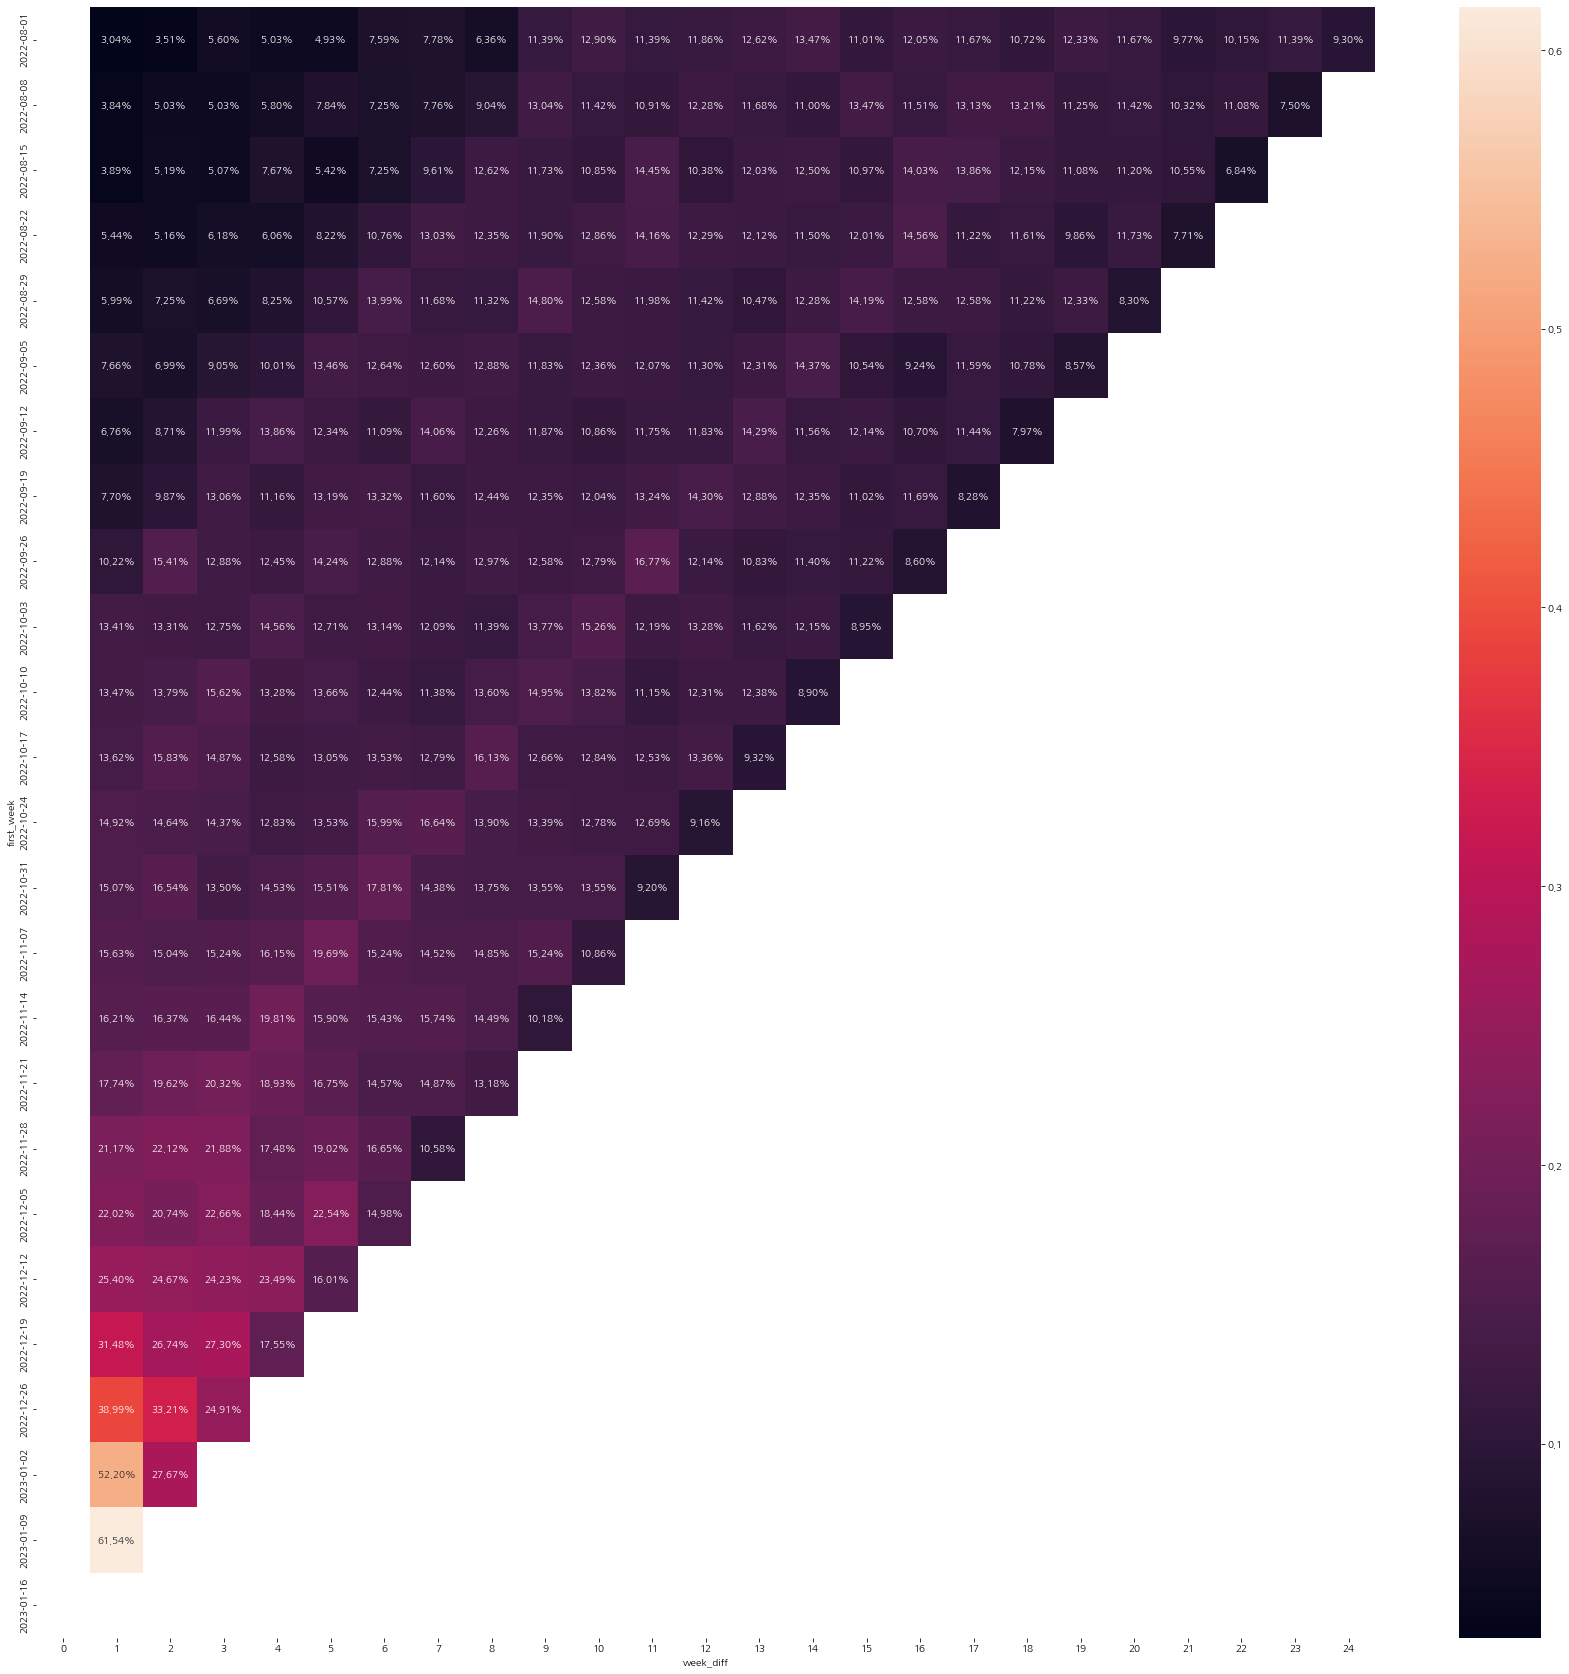

In [639]:
plt.figure(figsize=(30,30))

# 코호트 피봇 테이블에서 의미 없는 부분 (아래 절반 삼각형, 유입주차)
cohort_drop = cohort_revisit_pivot.isnull()
cohort_drop.iloc[:,0] = True

sns.heatmap(
    data = cohort_revisit_pivot,
    mask = cohort_drop,
    annot = True,
    fmt=".2%"
)

### 상관관계
#### 단기 vs. 중기 vs. 장기
- 각 그룹에 대해 동일 시간단위(day, week,...) 기준으로
  - active user와 주문율의 상관관계 계산

In [3]:
sql = f"""
WITH short_user_logs AS (
  -- 1) 단기 재방문 유저의 로그
  -- 단기 재방문 유저 전체 인원인 9661명, 분석 대상 로그 수 190787건
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'short'
  )
)
, short_dau_list AS (
  -- 단기 방문 유저의 dau
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau
  FROM short_user_logs
  GROUP BY event_date
  ORDER BY event_date
)
, short_order_cnt_list_d AS (
  -- 단기 방문 유저의 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM short_user_logs
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)

-- DAU와 일별 주문 유저 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM short_dau_list d
INNER JOIN short_order_cnt_list_d o ON d.event_date = o.event_date
ORDER BY d.event_date ASC;
"""

query_job = client.query(sql)
short_dau_order = query_job.to_dataframe()
short_dau_order.head()

,event_date,dau,order_users_cnt,order_ratio
0,2022-08-01,23,2,8.696
1,2022-08-02,18,4,22.222
2,2022-08-03,20,1,5.000
3,2022-08-04,23,2,8.696
4,2022-08-05,20,1,5.000


In [4]:
from scipy.stats import pearsonr, spearmanr

# 피어슨 상관계수
pearson_corr, pearson_p = pearsonr(short_dau_order['dau'], short_dau_order['order_ratio'])
print(pearson_corr, pearson_p)

# 스피어만 상관계수
spearman_corr, spearman_p = spearmanr(short_dau_order['dau'], short_dau_order['order_ratio'])
print(spearman_corr, spearman_p)

-0.15069815071975912 0.0478078865282389
-0.14623567813264401 0.05488069826652044


단기 방문 유저 기준 방문 유저 수가 많아질수록 주문율이 소폭 감소하는 경향이 있다.  
하지만 상관계수의 절댓값이 작고, p-value도 0.05와 근접하므로 통계적 유의성이 약하다.

In [5]:
sql = f"""
WITH mid_user_logs AS (
  -- 1) 중기 재방문 유저의 로그
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'mid'
  )
)
, mid_dau_list AS (
  -- 중기 방문 유저의 dau
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau
  FROM mid_user_logs
  GROUP BY event_date
  ORDER BY event_date
)
, mid_order_cnt_list_d AS (
  -- 중기 방문 유저의 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM mid_user_logs
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)

-- DAU와 일별 주문 유저 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM mid_dau_list d
INNER JOIN mid_order_cnt_list_d o ON d.event_date = o.event_date
ORDER BY d.event_date ASC;
"""

query_job = client.query(sql)
mid_dau_order = query_job.to_dataframe()
mid_dau_order.head()

,event_date,dau,order_users_cnt,order_ratio
0,2022-08-01,19,2,10.526
1,2022-08-02,16,3,18.750
2,2022-08-03,31,6,19.355
3,2022-08-04,29,6,20.690
4,2022-08-05,20,2,10.000


In [6]:
# 피어슨 상관계수
pearson_corr, pearson_p = pearsonr(mid_dau_order['dau'], mid_dau_order['order_ratio'])
print(pearson_corr, pearson_p)

# 스피어만 상관계수
spearman_corr, spearman_p = spearmanr(mid_dau_order['dau'], mid_dau_order['order_ratio'])
print(spearman_corr, spearman_p)

-0.12349406046732658 0.10550372621323419
-0.04788827230634996 0.5315348989883988


중기 방문 유저 기준 방문 유저 수가 많아질수록 주문율이 소폭 감소하는 경향이 있다.  
하지만 상관계수의 절댓값이 작고, p-value가 0.05보다 크므로 통계적 유의성이 없다.

In [7]:
sql = f"""
WITH long_user_logs AS (
  -- 1) 장기 재방문 유저의 로그
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'long'
  )
)
, long_dau_list AS (
  -- 장기 방문 유저의 dau
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau
  FROM long_user_logs
  GROUP BY event_date
  ORDER BY event_date
)
, long_order_cnt_list_d AS (
  -- 장기 방문 유저의 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM long_user_logs
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)

-- DAU와 일별 주문 유저 수 비교
-- 접속한 사람에 비해 주문까지 한 사람은 얼마나 될까?
SELECT
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM long_dau_list d
INNER JOIN long_order_cnt_list_d o ON d.event_date = o.event_date
ORDER BY d.event_date ASC;
"""

query_job = client.query(sql)
long_dau_order = query_job.to_dataframe()
long_dau_order.head()

,event_date,dau,order_users_cnt,order_ratio
0,2022-08-01,93,7,7.527
1,2022-08-02,105,12,11.429
2,2022-08-03,107,17,15.888
3,2022-08-04,89,3,3.371
4,2022-08-05,111,6,5.405


In [8]:
# 피어슨 상관계수
pearson_corr, pearson_p = pearsonr(long_dau_order['dau'], long_dau_order['order_ratio'])
print(pearson_corr, pearson_p)

# 스피어만 상관계수
spearman_corr, spearman_p = spearmanr(long_dau_order['dau'], long_dau_order['order_ratio'])
print(spearman_corr, spearman_p)

0.027593492013589203 0.7185680414259795
0.021353010180686586 0.7803593885815379


장기 방문 유저 기준 방문 유저 수가 많아질수록 주문율이 소폭 증가하는 경향이 있다.  
하지만 상관계수의 절댓값이 작고, p-value가 0.05보다 크므로 통계적 유의성이 없다.

#### 연휴 유입 vs. 연휴 외 유입

In [9]:
sql = f"""
WITH dau_list AS (
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau,
  FROM advanced.app_logs_cleaned_target
  GROUP BY event_date
)
, order_cnt_list_d AS (
  -- 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM advanced.app_logs_cleaned_target
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)
, dau_vs_order_user AS (
  -- DAU와 일별 주문 유저 수 비교
  SELECT
    d.event_date,
    d.dau,
    o.order_users_cnt,
    ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
  FROM dau_list d
  INNER JOIN order_cnt_list_d o ON d.event_date = o.event_date
)
, holiday AS (
  -- 연휴 정의
  SELECT
    event_date AS holiday_date,
    DATE_TRUNC(event_date, WEEK(MONDAY)) AS holiday_week
  FROM dau_vs_order_user
  WHERE order_ratio > 30
)



, revisit_user_logs AS (
  -- 1) 재방문 유저 로그
  SELECT
    *
  FROM advanced.app_logs_cleaned_target
  WHERE 1=1
  AND user_pseudo_id NOT IN (
    SELECT user_pseudo_id
    FROM advanced.app_logs_target_visit_seg
    WHERE visit_interval_cat = 'one_day'
  )
)

, week_diff_revisit_users AS (
  -- 2) 사용자별 첫방문일, 방문일, 방문간격(주차) 추출
  SELECT
    user_pseudo_id,
    first_date,
    event_date,
    DATE_DIFF(event_date, first_date, WEEK) AS week_diff,
  FROM (
  SELECT DISTINCT
    user_pseudo_id,
    MIN(event_date) OVER (PARTITION BY user_pseudo_id) AS first_date,
    event_date,
  FROM revisit_user_logs
  )
)

, revisit_holiday_logs AS (
  -- 재방문 + 연휴 유입 유저 로그
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    CONCAT(firebase_screen, ": ", event_name) AS screen_event,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id
    FROM week_diff_revisit_users
    WHERE first_date IN (SELECT holiday_date FROM holiday)
  )
)


, holiday_dau_list AS (
  -- 연휴 유입 유저의 dau
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau
  FROM revisit_holiday_logs
  GROUP BY event_date
  ORDER BY event_date
)
, holiday_order_cnt_list_d AS (
  -- 단기 방문 유저의 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM revisit_holiday_logs
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)




, revisit_normalday_logs AS (
  -- 재방문 + 연휴 외 유입 유저 로그
  SELECT
    event_datetime,
    event_date,
    event_time,
    event_week,
    event_dow,
    user_pseudo_id,
    user_id,
    firebase_screen,
    event_name,
    CONCAT(firebase_screen, ": ", event_name) AS screen_event,
  FROM advanced.app_logs_cleaned_target
  WHERE user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id
    FROM week_diff_revisit_users
    WHERE first_date NOT IN (SELECT holiday_date FROM holiday)
  )
)

, normalday_dau_list AS (
  -- 연휴 외 유입 유저의 dau
  SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS dau
  FROM revisit_normalday_logs
  GROUP BY event_date
  ORDER BY event_date
)
, normalday_order_cnt_list_d AS (
  -- 연휴 외 유입 유저의 일일 주문 유저 수
  SELECT
    event_date,
    COUNT(DISTINCT user_id) AS order_users_cnt
  FROM revisit_normalday_logs
  WHERE event_name = 'click_payment'
  GROUP BY event_date
)



SELECT
  'holiday' AS segment,
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM holiday_dau_list d
INNER JOIN holiday_order_cnt_list_d o ON d.event_date = o.event_date

UNION ALL

SELECT
  'normalday' AS segment,
  d.event_date,
  d.dau,
  o.order_users_cnt,
  ROUND(SAFE_DIVIDE(o.order_users_cnt, d.dau) * 100, 3) AS order_ratio
FROM normalday_dau_list d
INNER JOIN normalday_order_cnt_list_d o ON d.event_date = o.event_date


ORDER BY segment, event_date ASC;
"""

query_job = client.query(sql)
holiday_dau_order = query_job.to_dataframe()
holiday_dau_order.head()

,segment,event_date,dau,order_users_cnt,order_ratio
0,holiday,2022-08-15,216,75,34.722
1,holiday,2022-09-05,2,1,50.000
2,holiday,2022-09-09,311,117,37.621
3,holiday,2022-09-10,328,113,34.451
4,holiday,2022-09-11,335,124,37.015


In [10]:
holiday_ = holiday_dau_order.loc[holiday_dau_order['segment']=='holiday']
normalday_ = holiday_dau_order.loc[holiday_dau_order['segment']=='normalday']


# 피어슨 상관계수
pearson_corr, pearson_p = pearsonr(holiday_['dau'], holiday_['order_ratio'])
print(pearson_corr, pearson_p)

# 스피어만 상관계수
spearman_corr, spearman_p = spearmanr(holiday_['dau'], holiday_['order_ratio'])
print(spearman_corr, spearman_p)

# 피어슨 상관계수
pearson_corr, pearson_p = pearsonr(normalday_['dau'], normalday_['order_ratio'])
print(pearson_corr, pearson_p)

# 스피어만 상관계수
spearman_corr, spearman_p = spearmanr(normalday_['dau'], normalday_['order_ratio'])
print(spearman_corr, spearman_p)

0.5993636082063543 3.1340209358093925e-14
0.056029088881266426 0.5234058844885805
-0.3214614831137319 1.613908969177016e-05
-0.1256398400420011 0.09954011781578877


- 연휴 유입 유저: DAU와 주문율 사이에 강한 양의 선형 상관관계(피어슨 기준), 순위 기반 관계는 없음.
- 연휴 외 유입 유저: DAU와 주문율 사이에 약한 음의 선형 상관관계(피어슨 기준), 순위 기반 관계는 없음.
- 연휴에 유입된 경우는 방문 유저가 많아질수록 주문율도 증가
- 연휴 외 유입된 경우는 방문 유저가 증가할 때 주문율이 약간 감소한다.